In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)

        # print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        #print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        for i in range(target.size(0)):
            if i == 0:
                f_grad = torch.gradient(target[i], spacing = space, edge_order  = 1)[0]
            else:
                f_grad = torch.vstack([f_grad, torch.gradient(target[i], spacing = space, edge_order  = 1)[0]])
        return f_grad
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output
    
    def masking(self, target):
    
        # value_masking vector
        value_masking = torch.where(target.isnan(), 0.0, 1.0).to(torch.float64)

        # gradient masking vector
        dim1 = (target.isnan().nonzero(as_tuple=True)[0]).detach().cpu().to().tolist()
        dim2_backward = (target.isnan().nonzero(as_tuple=True)[1] + 1).detach().cpu().to().tolist()
        dim2_forward = (target.isnan().nonzero(as_tuple=True)[1] -1).detach().cpu().to().tolist()

        grad_masking = torch.where(target.isnan(), 0.0, 1.0).to(torch.float64)
        #grad_masking[dim1, dim2_backward] = 0.0
        #grad_masking[dim1, dim2_forward] = 0.0
        
        return value_masking, grad_masking


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)

        # observation_len = torch.sum(self.value_masking)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)
        # deltaSigma = torch.sum(deltaSigma1, dim=2) / observation_len + torch.sum(deltaSigma2, dim=2) / observation_len

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        
        deltaCenter =  torch.mean(torch.sum(deltaCenter1, dim=2), dim = 0) + torch.mean(torch.sum(deltaCenter2, dim=2), dim = 0)
        # deltaCenter =  torch.sum(deltaCenter1, dim=2) / observation_len + torch.sum(deltaCenter2, dim=2) / observation_len
        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_, R) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.weights -= self.lr * delta_weight
        #self.centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_num, 1)
        #self.sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_num, 1)
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        best_pred_masking = best_pred * self.value_masking
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[i]).cpu().detach().numpy())
                ax[i].scatter(input_data.cpu().detach().numpy(), best_pred_masking[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.scatter(input_data.cpu().detach().numpy(), torch.nan_to_num(self.target[0]).cpu().detach().numpy())
            plt.scatter(input_data.cpu().detach().numpy(), best_pred_masking[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.sum(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) / torch.sum(self.value_masking)
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.value_masking, self.grad_masking = self.masking(self.target)
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, torch.nan_to_num(self.target))
                first_grad = torch.nan_to_num(self.first_grad(input_data, target))

                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    pred *= self.value_masking 
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) * self.value_masking

                    self.BP(input_data, torch.nan_to_num(self.target), R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    pred *= self.value_masking 
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) * self.value_masking
                    epoch_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, torch.nan_to_num(self.target))

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    pred *= self.value_masking
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights) * self.value_masking
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, torch.nan_to_num(target_grad))))
                        self.best_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, torch.nan_to_num((target_grad).clone().detach()))
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, torch.nan_to_num(self.target), R, pred, torch.nan_to_num(target_grad), rbf_grad)
                    # R, pred = self.forward(input_data)
                    # rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, torch.nan_to_num(self.target), rbf_grad, torch.nan_to_num(target_grad))

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight) * self.value_masking
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight) * self.value_masking
            if self.number ==0:
                train_loss = self.Loss(best_pred, torch.nan_to_num(self.target), best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, torch.nan_to_num(self.target), best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

In [3]:
def gaussian(input_data, centers, sigma, weights):
    out = torch.exp(-1 *(torch.pow((input_data - centers), 2)) / (torch.pow(sigma, 2)))
    pred = torch.mm(weights, out)
    return pred

In [4]:
r_c = torch.tensor([1.32141,7.123, 16.1256142, 24.21512, 33.16512,52.13, 47.1626, 58.735, 72.1624, 90.123, 102.,51, 110.25, 120.51], dtype = torch.float64 ,device= device).reshape(14,1)
r_s = torch.tensor([1.1,2.3, 3.6142, 7.21512, 11.162, 3.626, 2.735, 6.1624, 1.2, 2,25, 3.12, 1.25, 5.21], dtype = torch.float64 ,device= device).reshape(14,1)
r_w = torch.tensor([[-10,4, 12, 32, -33, 12, -20, 3, 10, -12, 21, 5, 2,-2],
                    [12,3, -1, -22, 3, 32, -20, 4, 2, 2, -20, 12, 3, 1],
                    [-10,5, 3, 23, -13, 23, 17, 2, 5, -3, 10, -12, 20, -7]], dtype = torch.float64, device = device)
input_ = np.arange(1,130,1)
input_ = torch.tensor(input_, dtype = torch.float64,device = device)


In [5]:
target = gaussian(input_, r_c, r_s, r_w)
target2 = gaussian(input_, r_c, r_s, r_w)

In [6]:
def plot_data(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].scatter(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.scatter(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

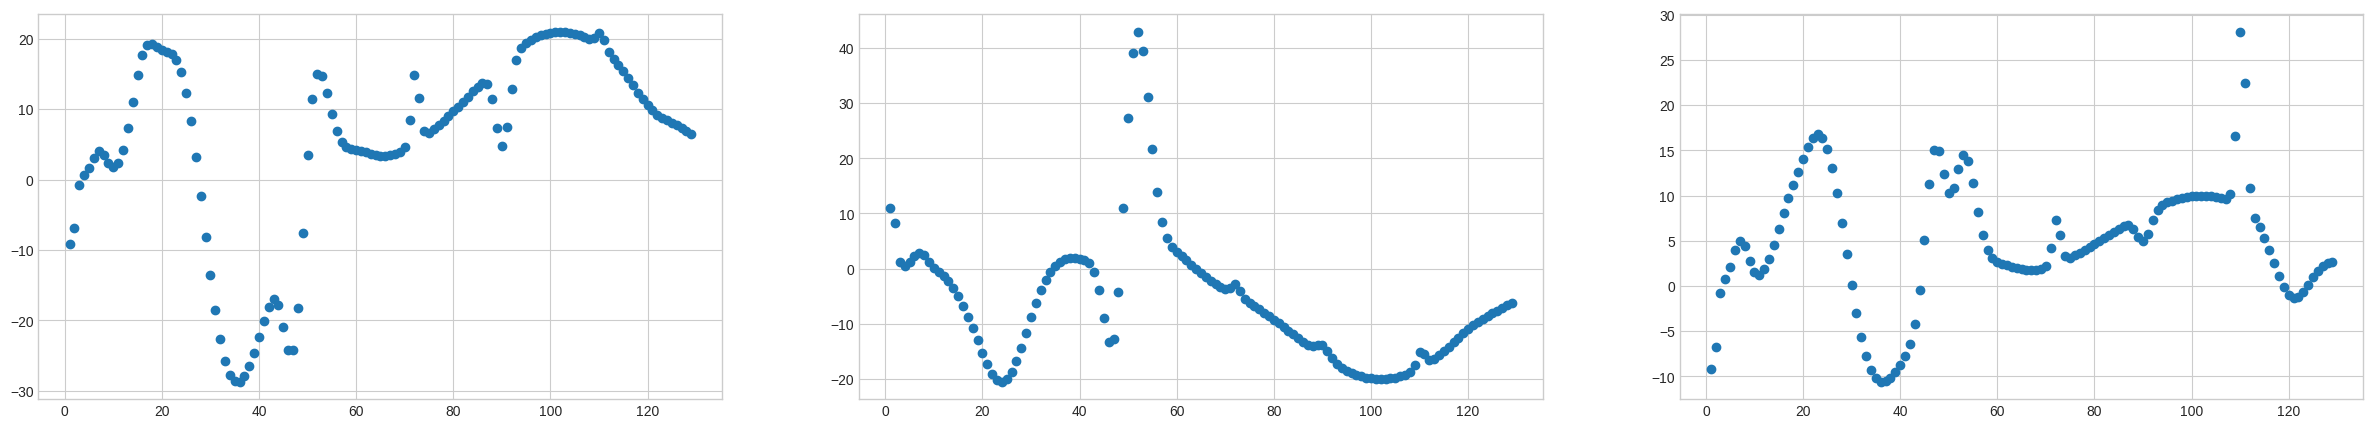

In [7]:
plot_data(input_, target.size(0), target)

In [8]:
for i in range(input_.size()[0] // 3):
    target[0][(i) * 3] = torch.nan
for i in range(input_.size()[0] // 4):
    target[0][(i+1) * 4] = torch.nan
for j in range(input_.size()[0] // 6):
    target[1][(j+1) * 6] = torch.nan
for k in range(input_.size()[0] // 9):
    target[2][(k+1) * 9] = torch.nan

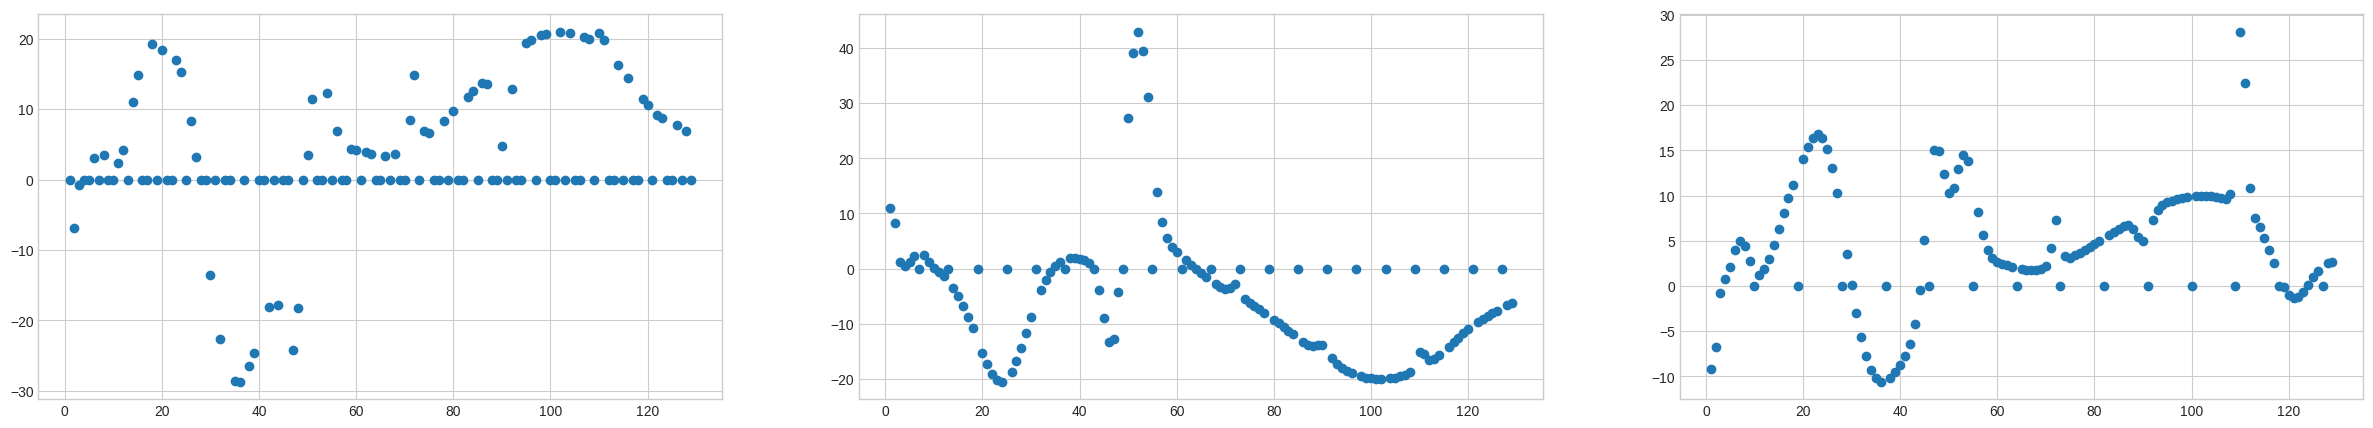

In [10]:
plot_data(input_, target.size(0), torch.nan_to_num(target))

In [9]:
torch.sum(torch.nan_to_num(target) == 0, dim = 1)

tensor([65, 21, 14], device='cuda:0')

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 520.1887575746697
0th additional RBFlayer 999th epoch MSE Loss: 52.43591621500319
0th additional RBFlayer 1999th epoch MSE Loss: 42.60979494195115
0th additional RBFlayer 2999th epoch MSE Loss: 37.09034353365417
0th additional RBFlayer best loss : 37.09034353365417


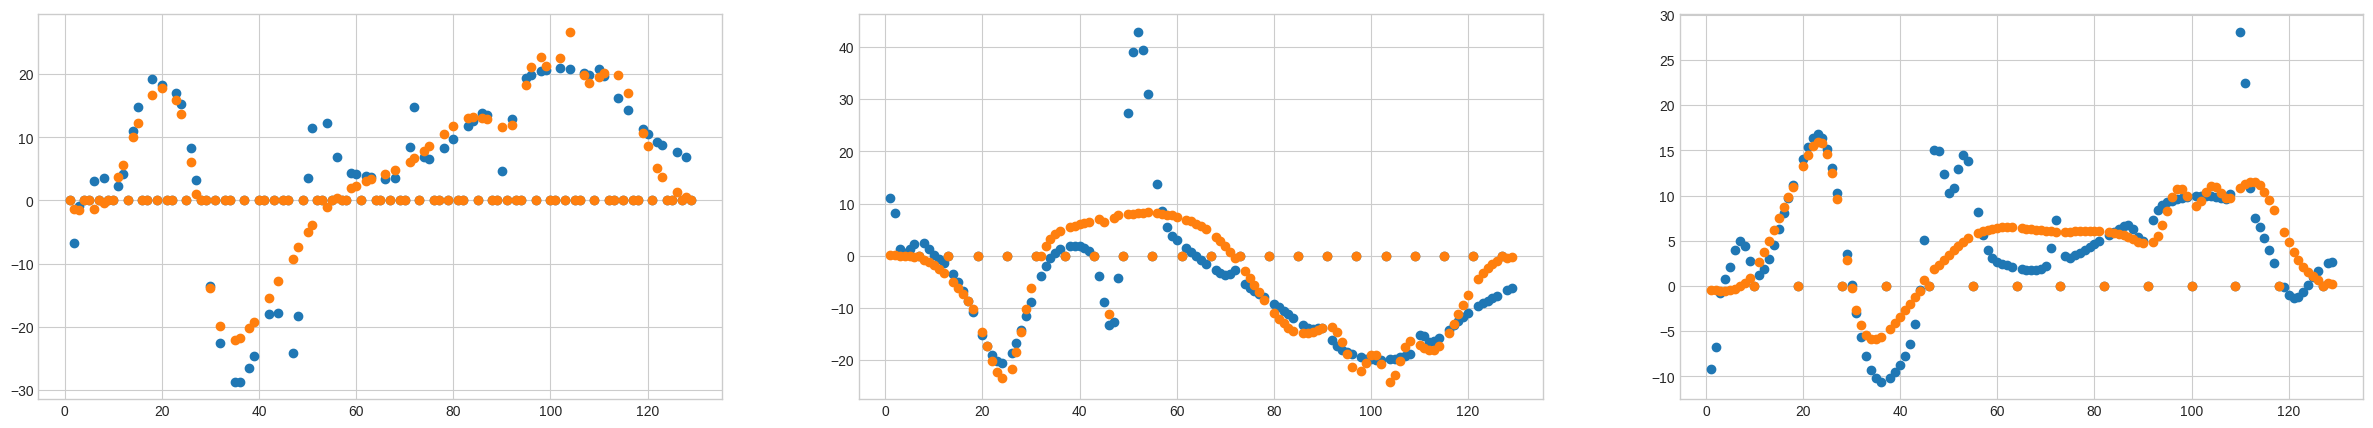

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 96.17177085415338
1th additional RBFlayer 999th epoch MSE Loss: 17.721875573755444
1th additional RBFlayer 1999th epoch MSE Loss: 15.521541914247056
1th additional RBFlayer 2999th epoch MSE Loss: 18.22599068028705
1th additional RBFlayer best loss : 15.241567196694147


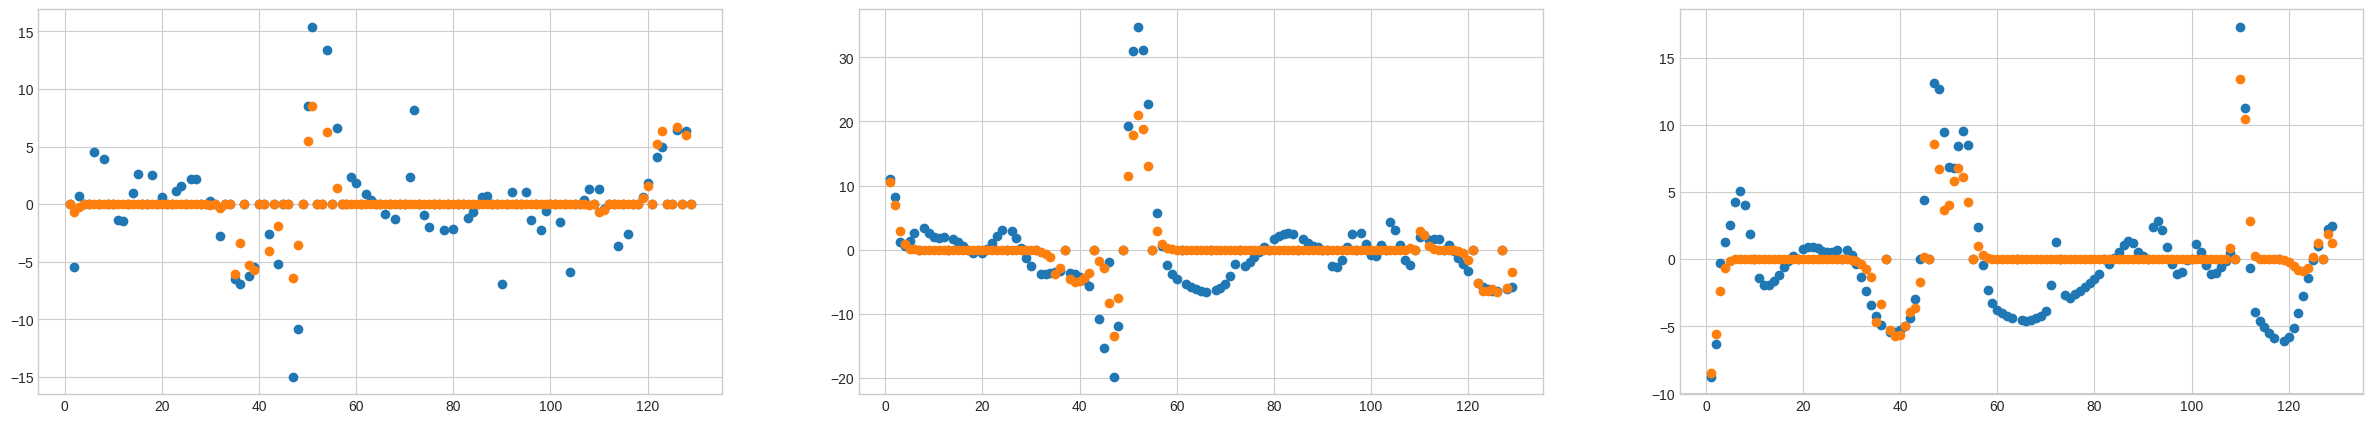

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 58.912729891494266
2th additional RBFlayer 999th epoch MSE Loss: 16.499494279586944
2th additional RBFlayer 1999th epoch MSE Loss: 16.251198368409458
2th additional RBFlayer 2999th epoch MSE Loss: 16.142252240613914
2th additional RBFlayer best loss : 16.14205447359658


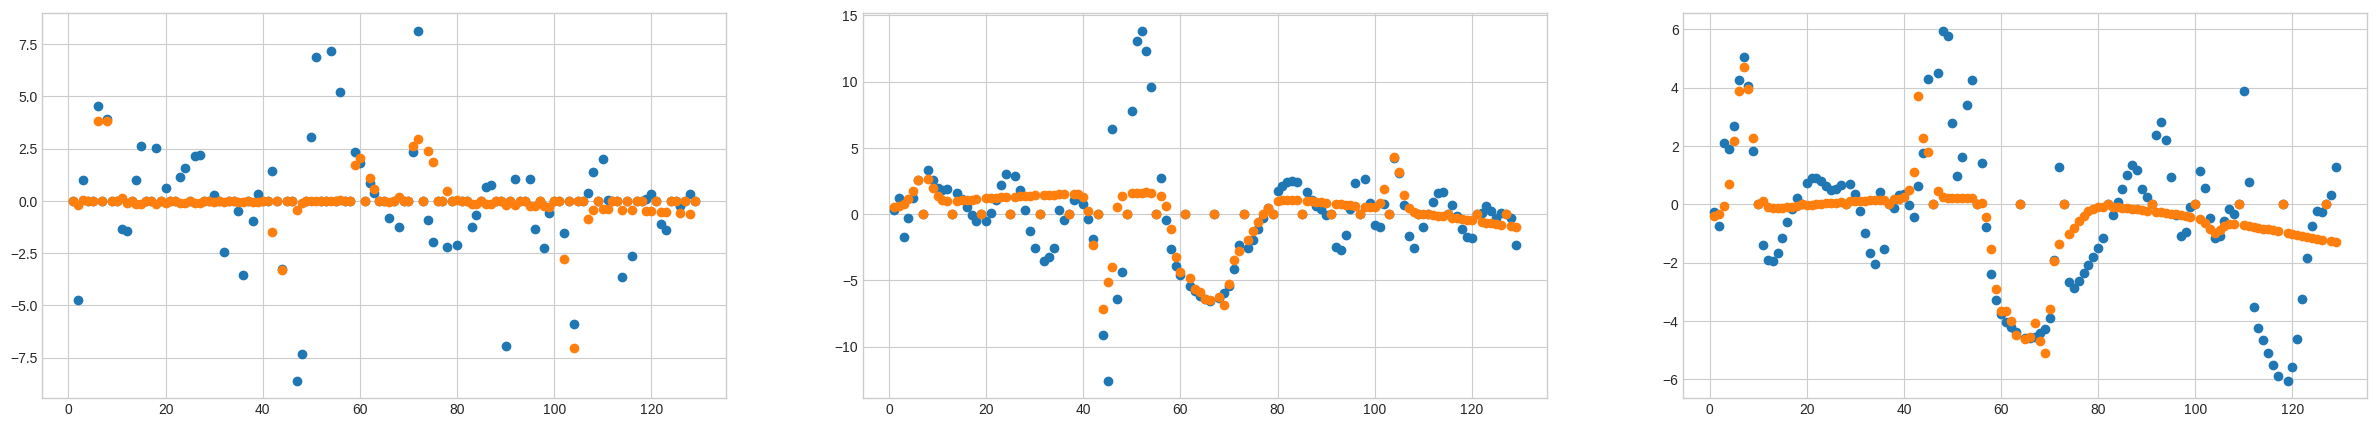

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 26.745032726594467
3th additional RBFlayer 999th epoch MSE Loss: 14.233384463938927
3th additional RBFlayer 1999th epoch MSE Loss: 13.328884286875454
3th additional RBFlayer 2999th epoch MSE Loss: 13.417815995066215
3th additional RBFlayer best loss : 12.906377003636772


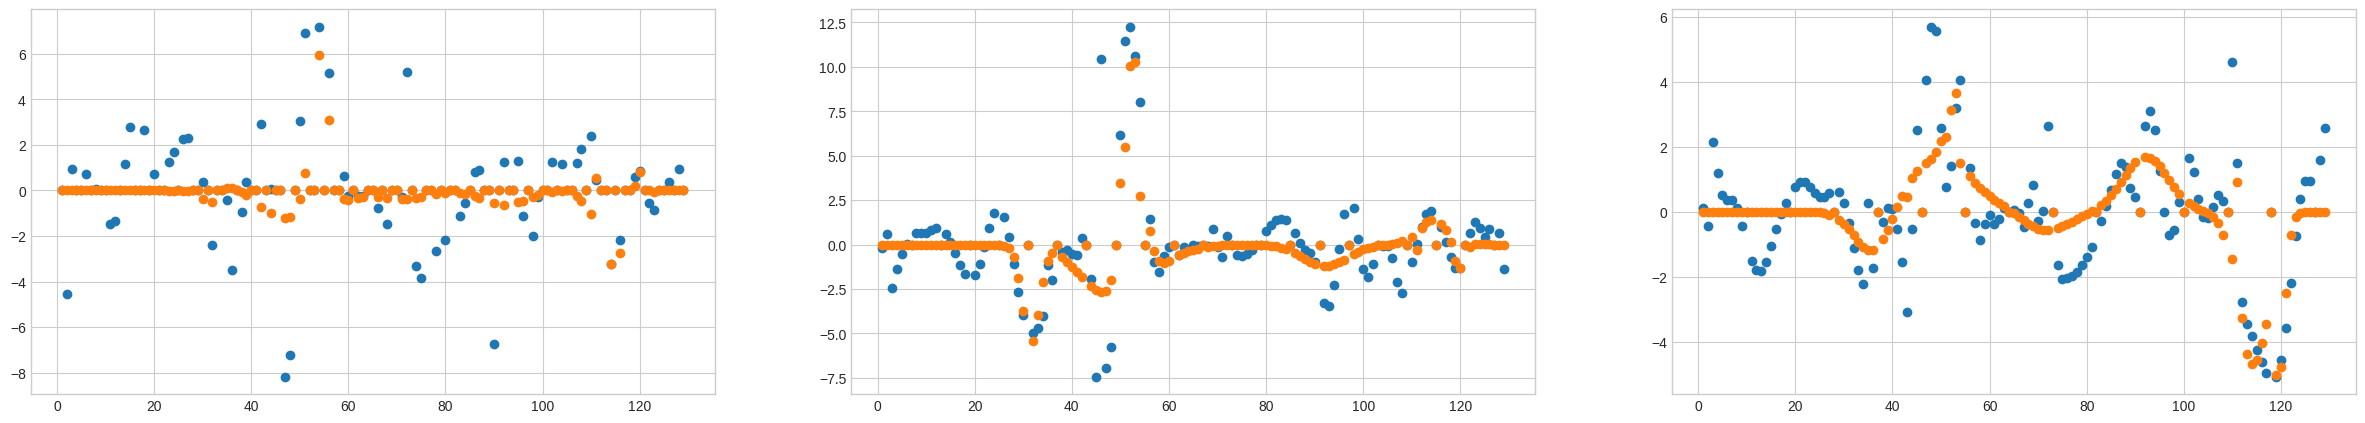

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 13.667631818886331
4th additional RBFlayer 999th epoch MSE Loss: 12.312733987562366
4th additional RBFlayer 1999th epoch MSE Loss: 12.236849692321933
4th additional RBFlayer 2999th epoch MSE Loss: 12.551807984419632
4th additional RBFlayer best loss : 11.931438288410424


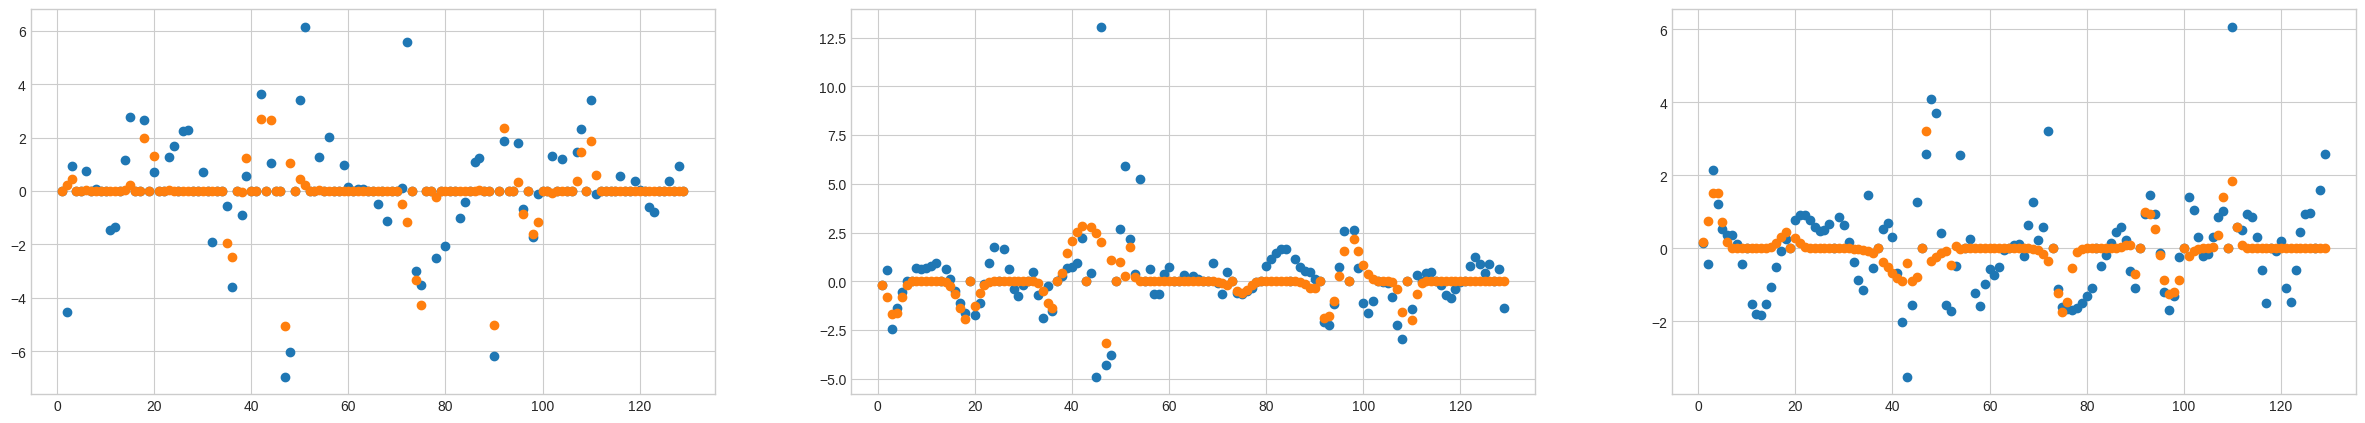

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 38.557946429632175
5th additional RBFlayer 999th epoch MSE Loss: 11.669418351494448
5th additional RBFlayer 1999th epoch MSE Loss: 11.599569581451856
5th additional RBFlayer 2999th epoch MSE Loss: 11.514757511731132
5th additional RBFlayer best loss : 11.514757511731132


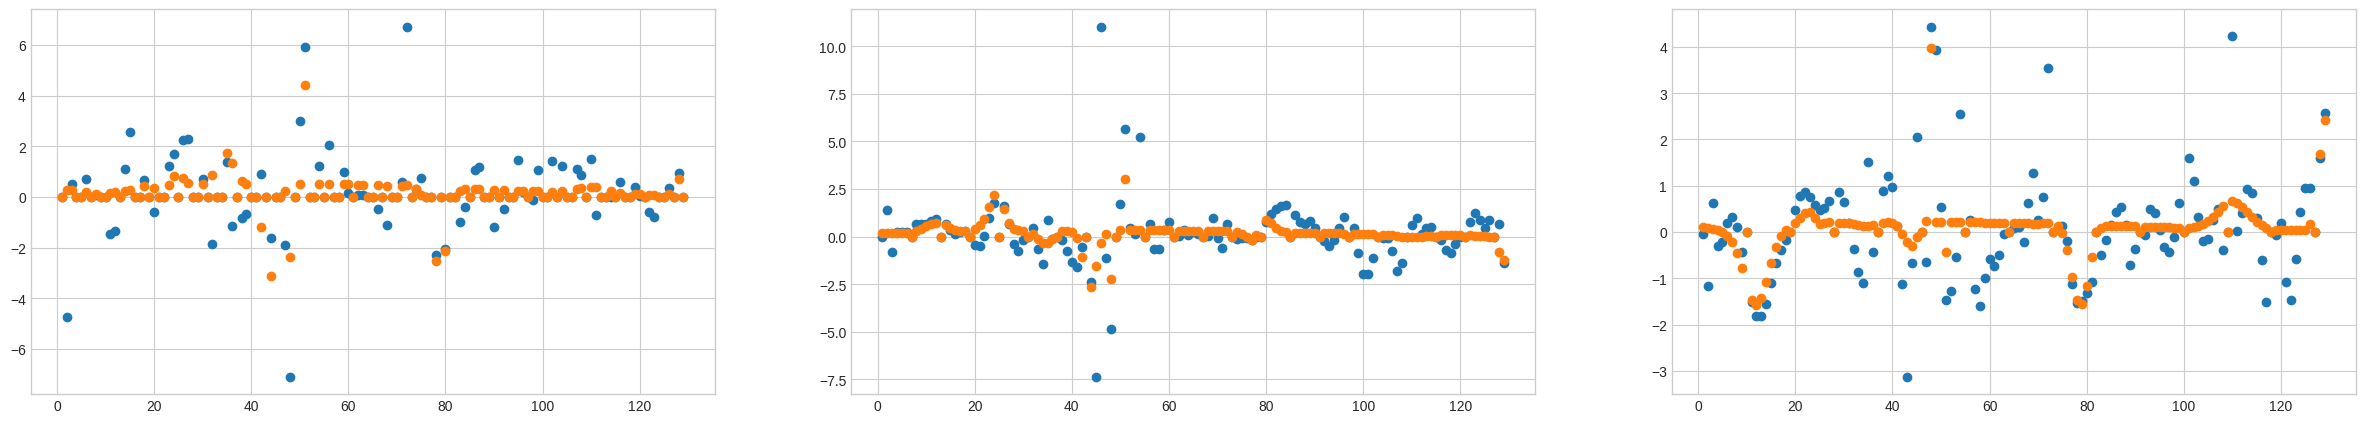

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 13.191631983704553
6th additional RBFlayer 999th epoch MSE Loss: 10.850442394164071
6th additional RBFlayer 1999th epoch MSE Loss: 10.787139089586546
6th additional RBFlayer 2999th epoch MSE Loss: 10.676915139335442
6th additional RBFlayer best loss : 10.64392943127882


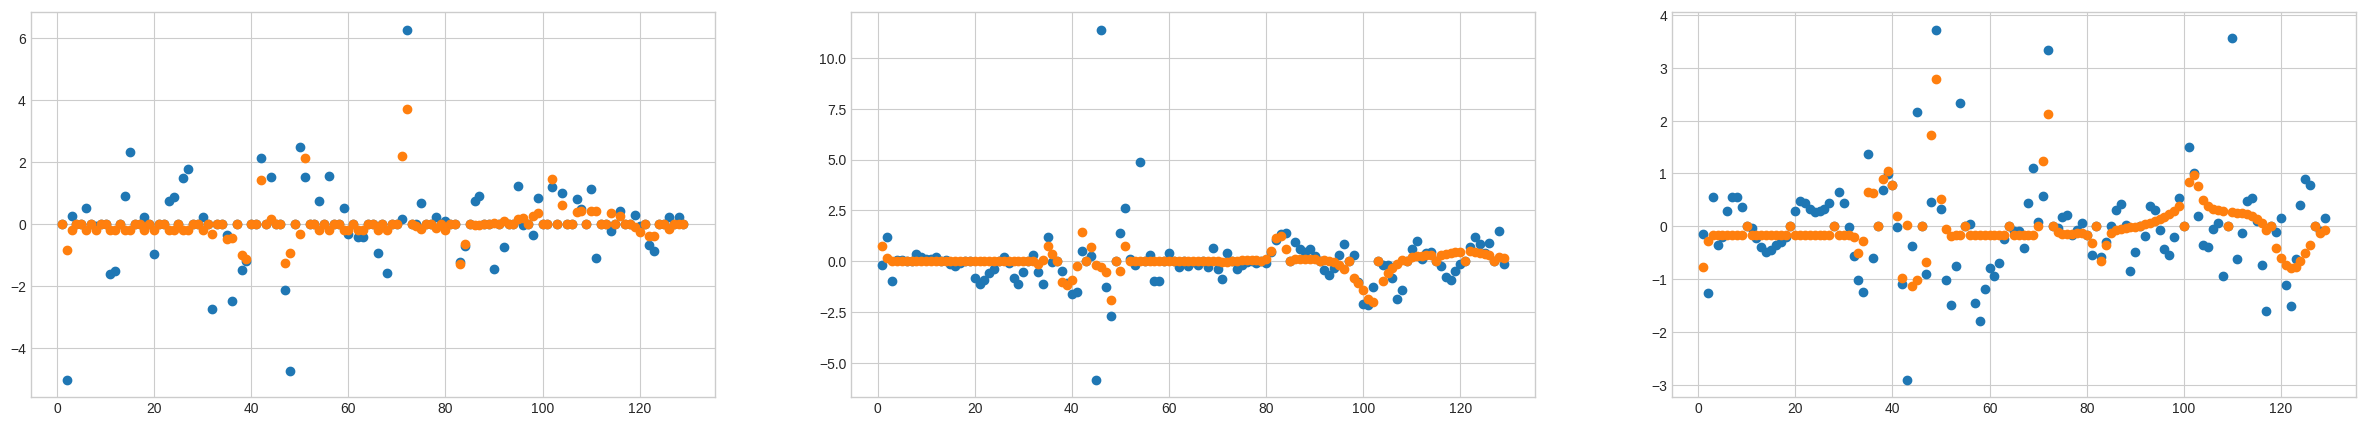

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 14.886569031043686
7th additional RBFlayer 999th epoch MSE Loss: 11.95254812890196
7th additional RBFlayer 1999th epoch MSE Loss: 10.726507348294657
7th additional RBFlayer 2999th epoch MSE Loss: 10.670557246474434
7th additional RBFlayer best loss : 10.670465350983228


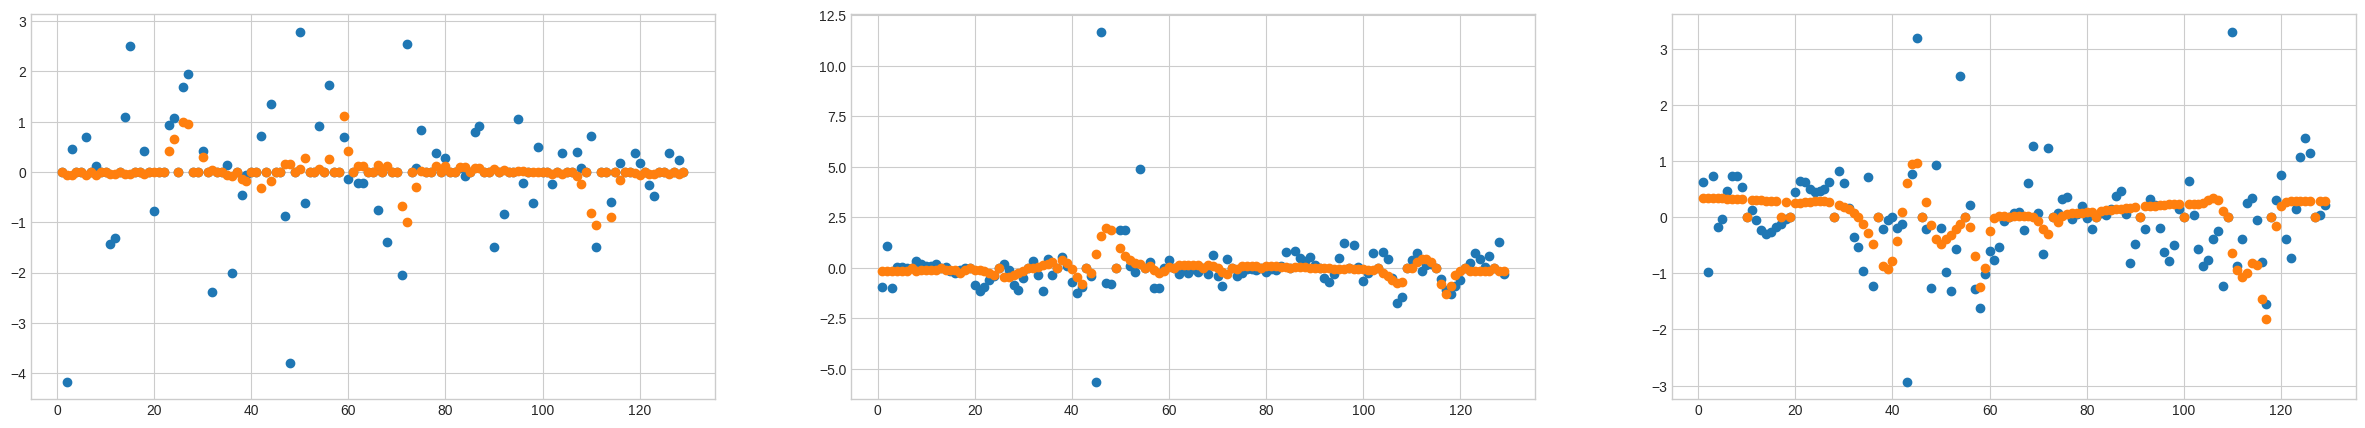

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 10.999685743099883
8th additional RBFlayer 999th epoch MSE Loss: 11.100046197751645
8th additional RBFlayer 1999th epoch MSE Loss: 10.593788312423117
8th additional RBFlayer 2999th epoch MSE Loss: 10.429758099261157
8th additional RBFlayer best loss : 10.429744934929339


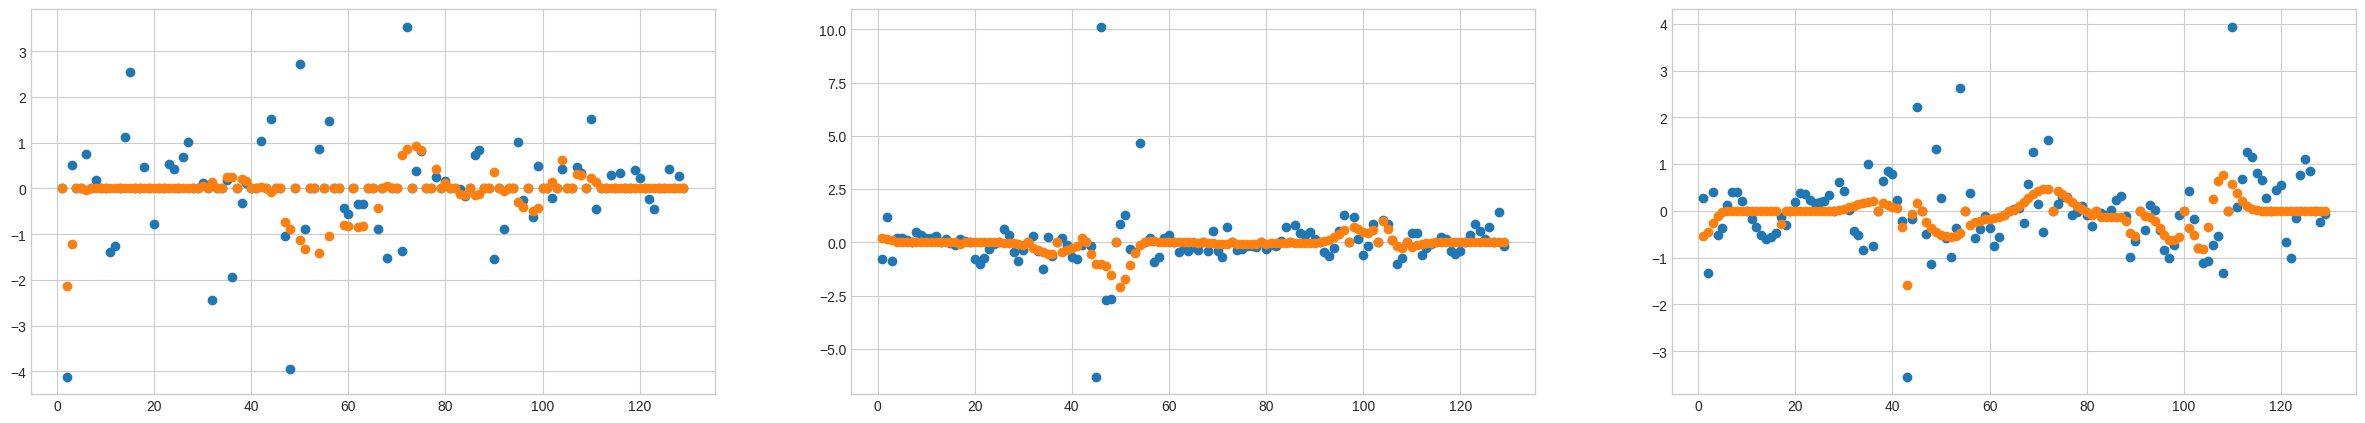

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 11.254880840132392
9th additional RBFlayer 999th epoch MSE Loss: 10.622807103686464
9th additional RBFlayer 1999th epoch MSE Loss: 9.964178640206983
9th additional RBFlayer 2999th epoch MSE Loss: 10.038281819423375
9th additional RBFlayer best loss : 9.96415641497074


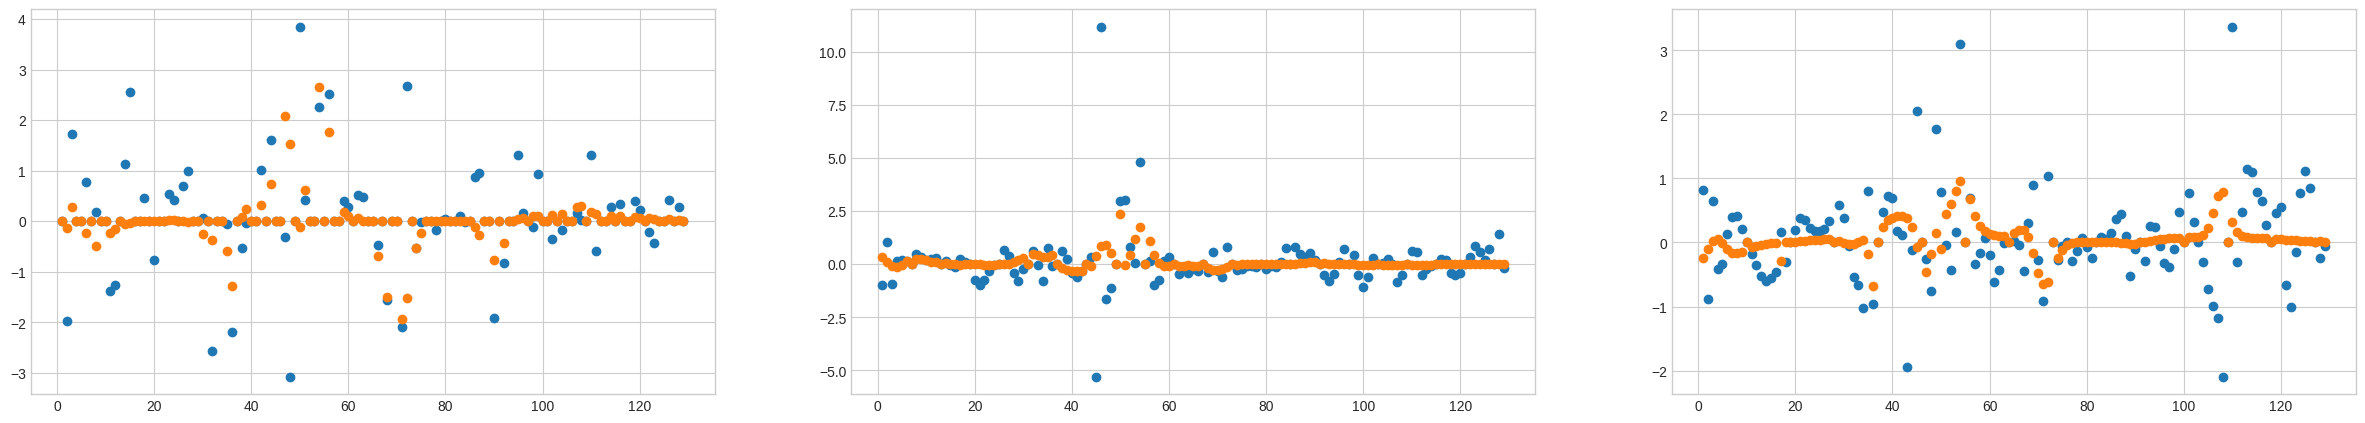

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 13.202610839972829
10th additional RBFlayer 999th epoch MSE Loss: 10.30524510931953
10th additional RBFlayer 1999th epoch MSE Loss: 10.171772498082763
10th additional RBFlayer 2999th epoch MSE Loss: 10.156330889212558
10th additional RBFlayer best loss : 10.149719712154164


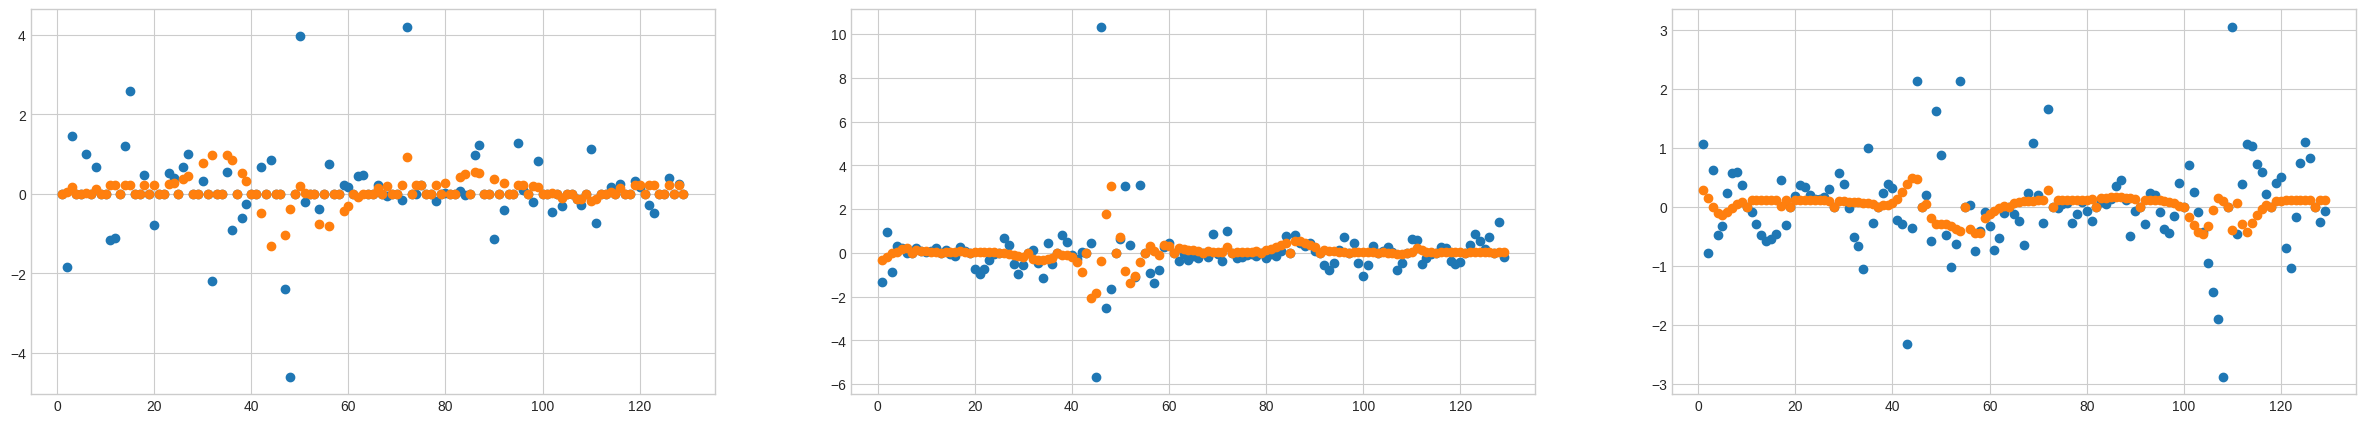

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 10.17419766498243
11th additional RBFlayer 999th epoch MSE Loss: 10.306934627428559
11th additional RBFlayer 1999th epoch MSE Loss: 9.772978734388564
11th additional RBFlayer 2999th epoch MSE Loss: 9.775108317037247
11th additional RBFlayer best loss : 9.701348953117517


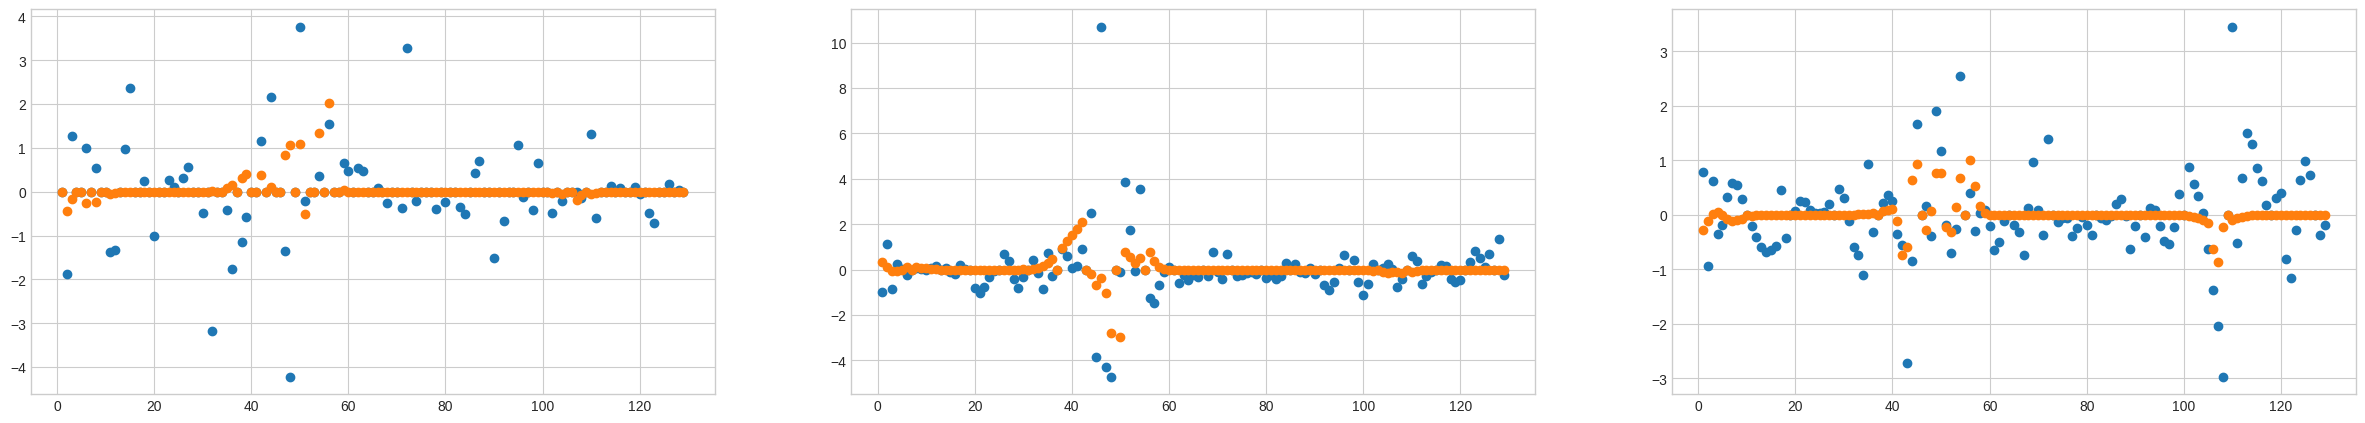

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 9.930378312818732
12th additional RBFlayer 999th epoch MSE Loss: 9.690101497468659
12th additional RBFlayer 1999th epoch MSE Loss: 9.430949436799791
12th additional RBFlayer 2999th epoch MSE Loss: 9.509252189774378
12th additional RBFlayer best loss : 9.41934634620374


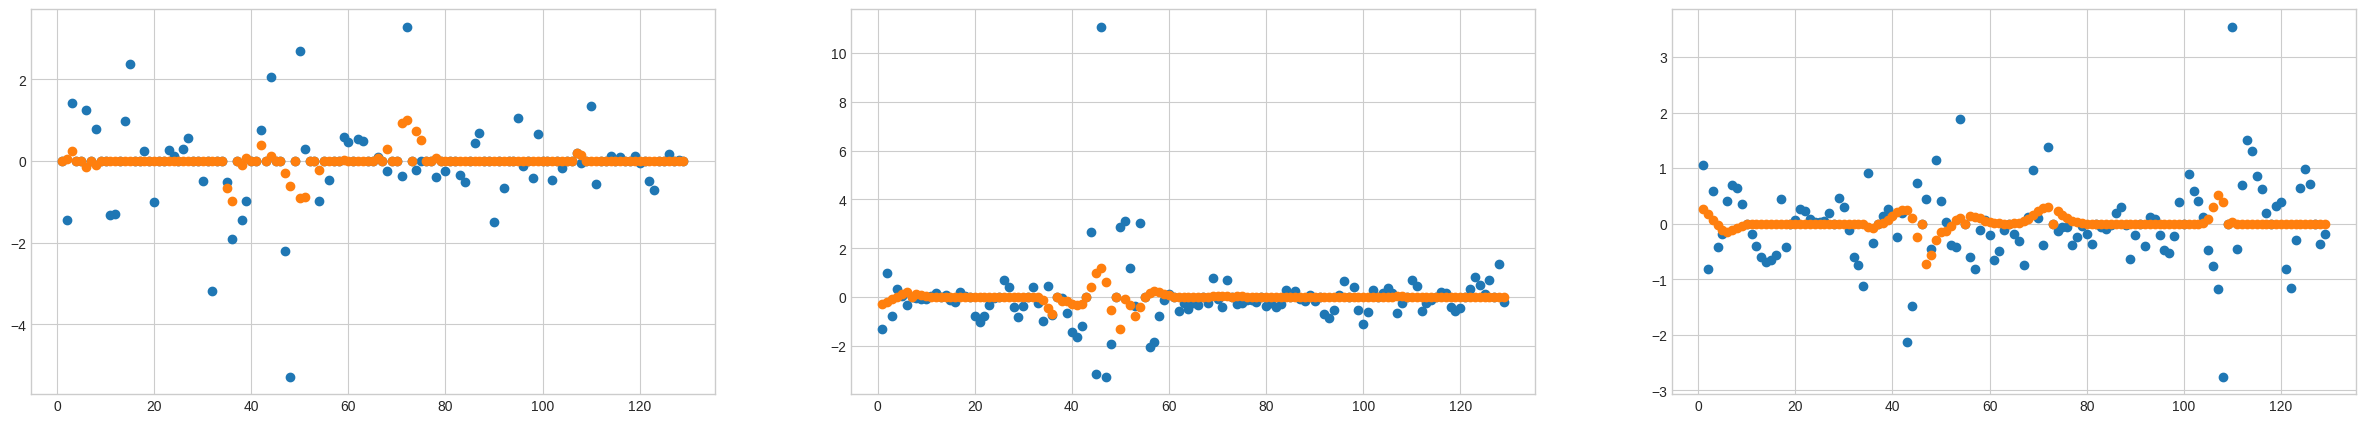

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 13.5588004273315
13th additional RBFlayer 999th epoch MSE Loss: 9.446089625357086
13th additional RBFlayer 1999th epoch MSE Loss: 9.169970932697863
13th additional RBFlayer 2999th epoch MSE Loss: 9.192447111057552
13th additional RBFlayer best loss : 9.140594584022782


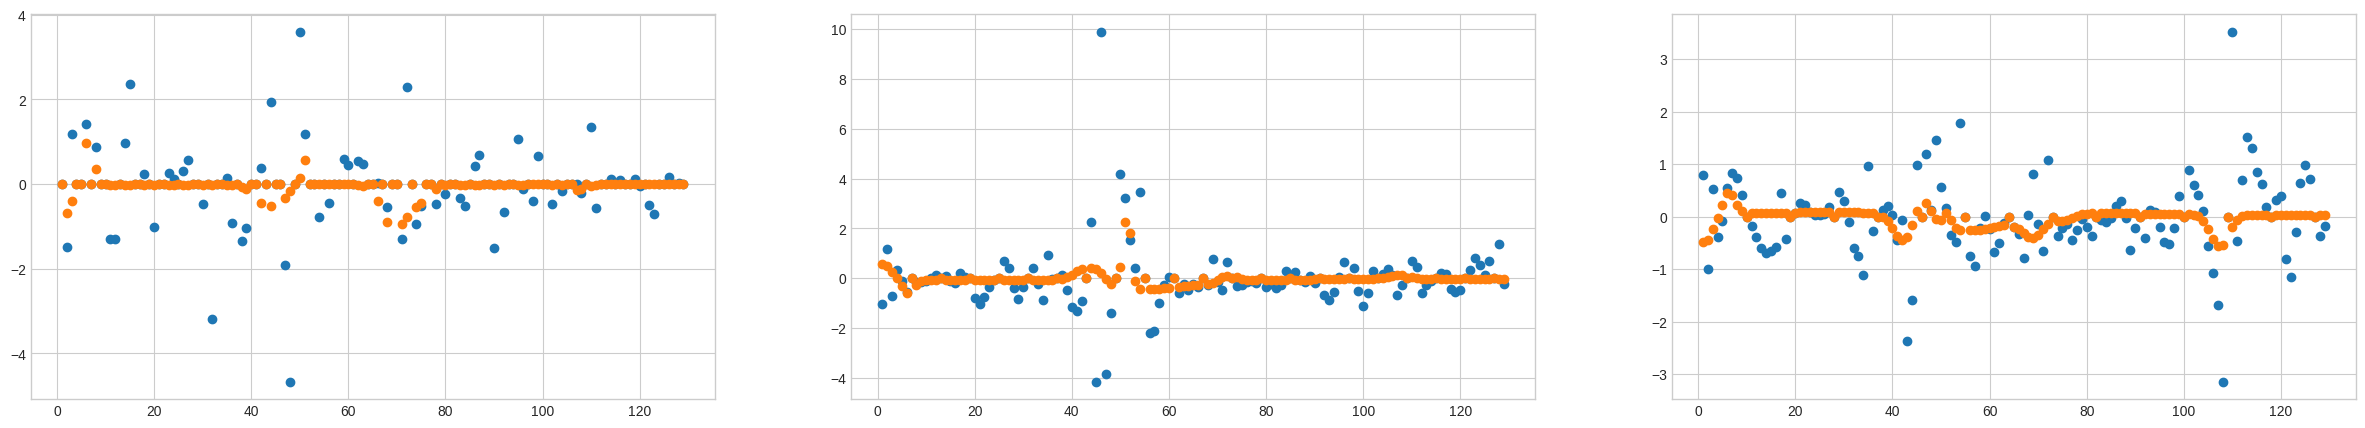

14th additional rbflayer
14th additional RBFlayer 0th epoch loss: 9.912684733477953
14th additional RBFlayer 999th epoch MSE Loss: 9.489057569163469
14th additional RBFlayer 1999th epoch MSE Loss: 9.456483430343203
14th additional RBFlayer 2999th epoch MSE Loss: 9.335416027891435
14th additional RBFlayer best loss : 9.334515813961008


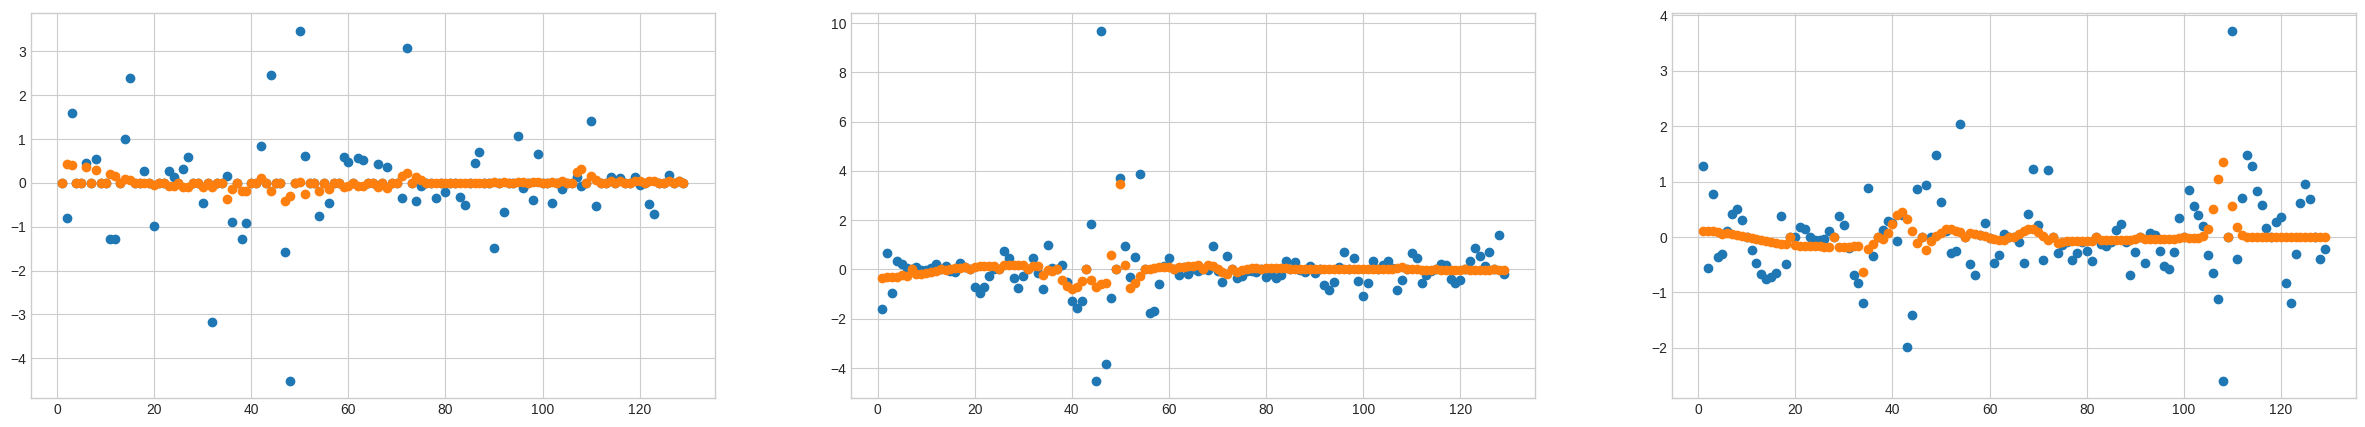

15th additional rbflayer
15th additional RBFlayer 0th epoch loss: 10.708183380491844
15th additional RBFlayer 999th epoch MSE Loss: 9.883248004269483
15th additional RBFlayer 1999th epoch MSE Loss: 9.498343959896573
15th additional RBFlayer 2999th epoch MSE Loss: 9.572640436524807
15th additional RBFlayer best loss : 9.486313425067992


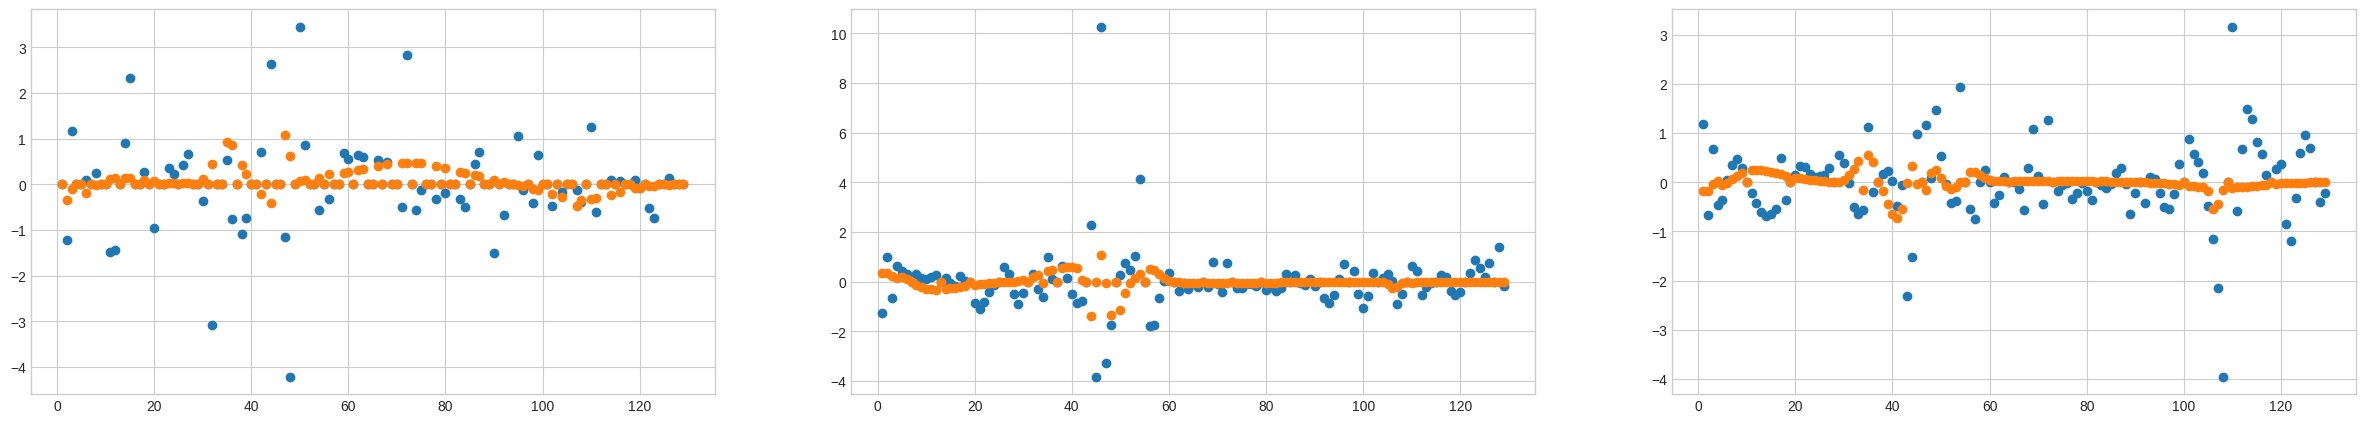

16th additional rbflayer
16th additional RBFlayer 0th epoch loss: 9.543023953969707
16th additional RBFlayer 999th epoch MSE Loss: 9.259928426244425
16th additional RBFlayer 1999th epoch MSE Loss: 9.237410003656946
16th additional RBFlayer 2999th epoch MSE Loss: 9.220923541095923
16th additional RBFlayer best loss : 9.220909582798924


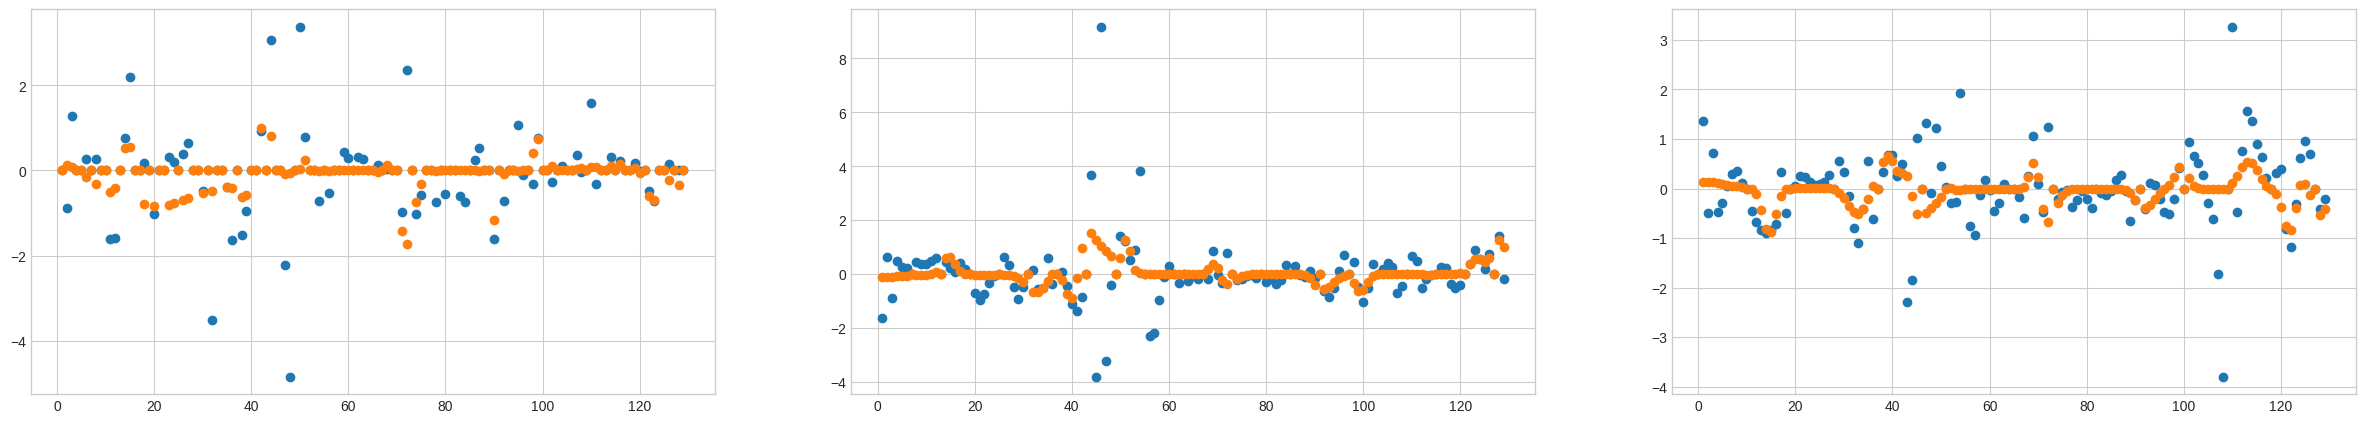

17th additional rbflayer
17th additional RBFlayer 0th epoch loss: 12.31928411183748
17th additional RBFlayer 999th epoch MSE Loss: 9.500958866480625
17th additional RBFlayer 1999th epoch MSE Loss: 9.368402494644636
17th additional RBFlayer 2999th epoch MSE Loss: 9.30963638889136
17th additional RBFlayer best loss : 9.308500291947686


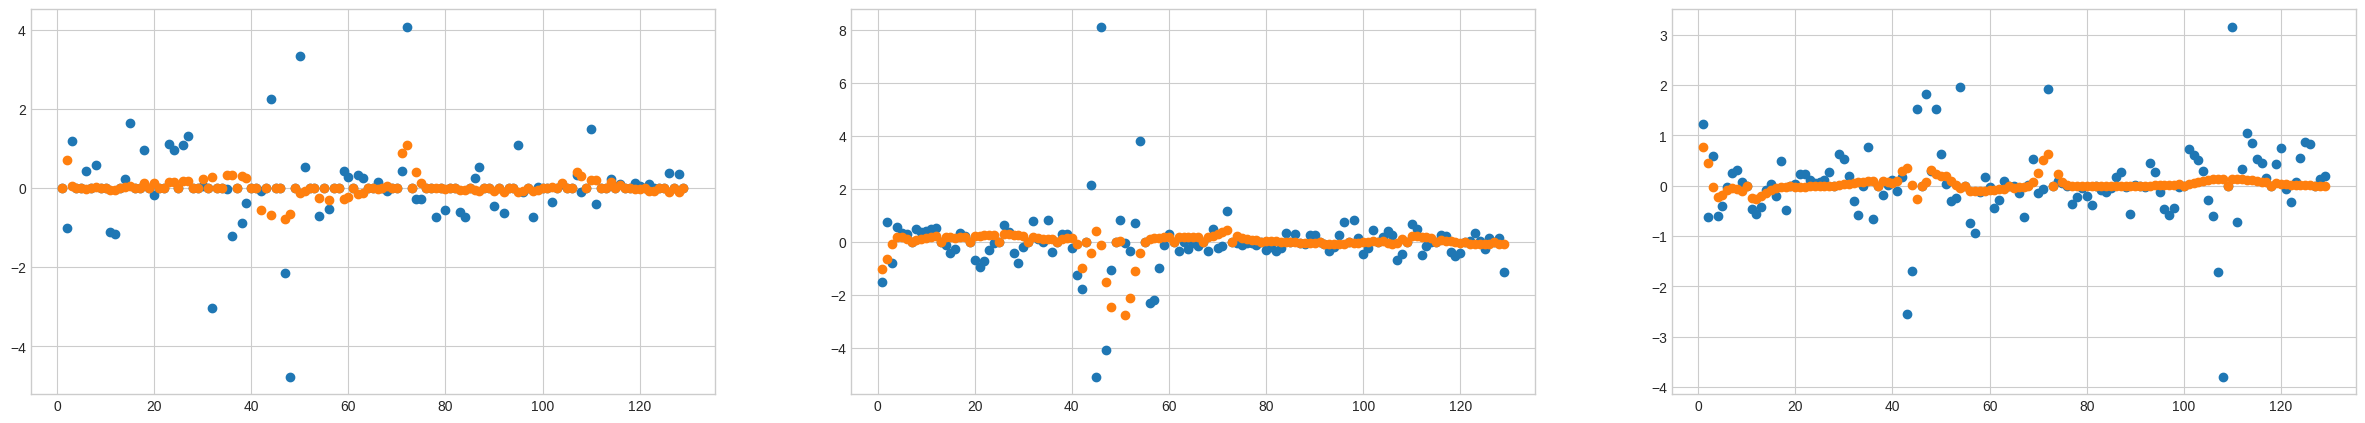

18th additional rbflayer
18th additional RBFlayer 0th epoch loss: 10.61048675481935
18th additional RBFlayer 999th epoch MSE Loss: 10.173157396284267
18th additional RBFlayer 1999th epoch MSE Loss: 9.700158206529643
18th additional RBFlayer 2999th epoch MSE Loss: 9.714976957082193
18th additional RBFlayer best loss : 9.700019402155329


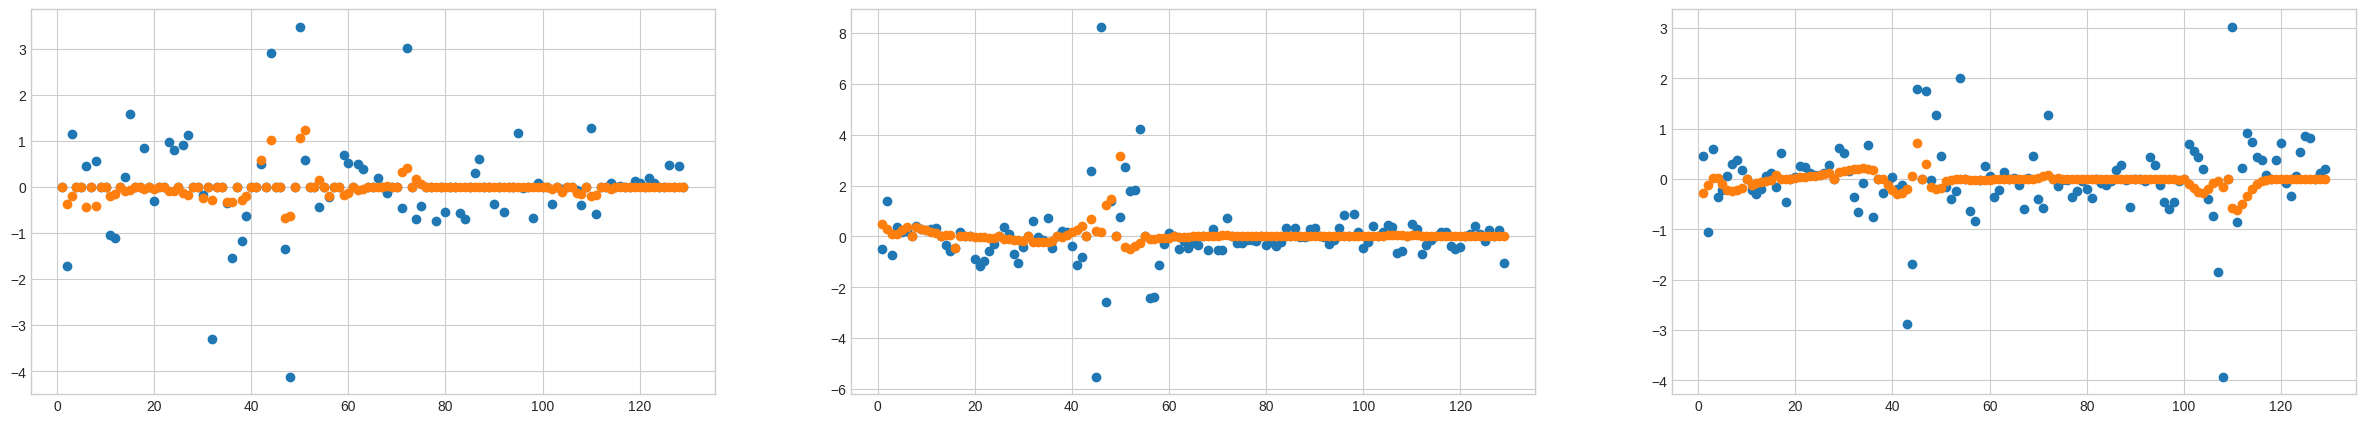

19th additional rbflayer
19th additional RBFlayer 0th epoch loss: 9.946259929224858
19th additional RBFlayer 999th epoch MSE Loss: 9.635340402147287
19th additional RBFlayer 1999th epoch MSE Loss: 9.616538202125698
19th additional RBFlayer 2999th epoch MSE Loss: 9.628235811448224
19th additional RBFlayer best loss : 9.615808162007614


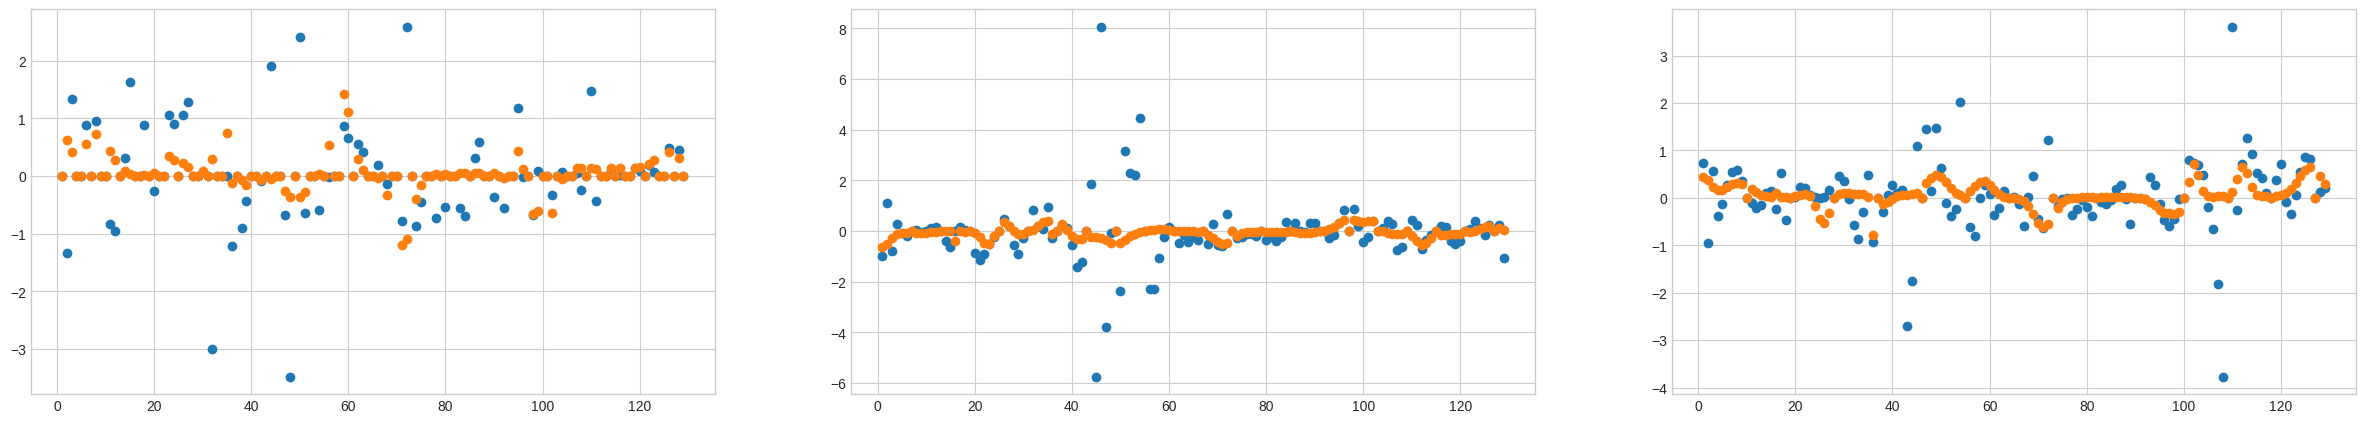

20th additional rbflayer
20th additional RBFlayer 0th epoch loss: 11.679240089027818
20th additional RBFlayer 999th epoch MSE Loss: 9.828148361656757
20th additional RBFlayer 1999th epoch MSE Loss: 9.495879661212648
20th additional RBFlayer 2999th epoch MSE Loss: 9.377117281597586
20th additional RBFlayer best loss : 9.377090084242319


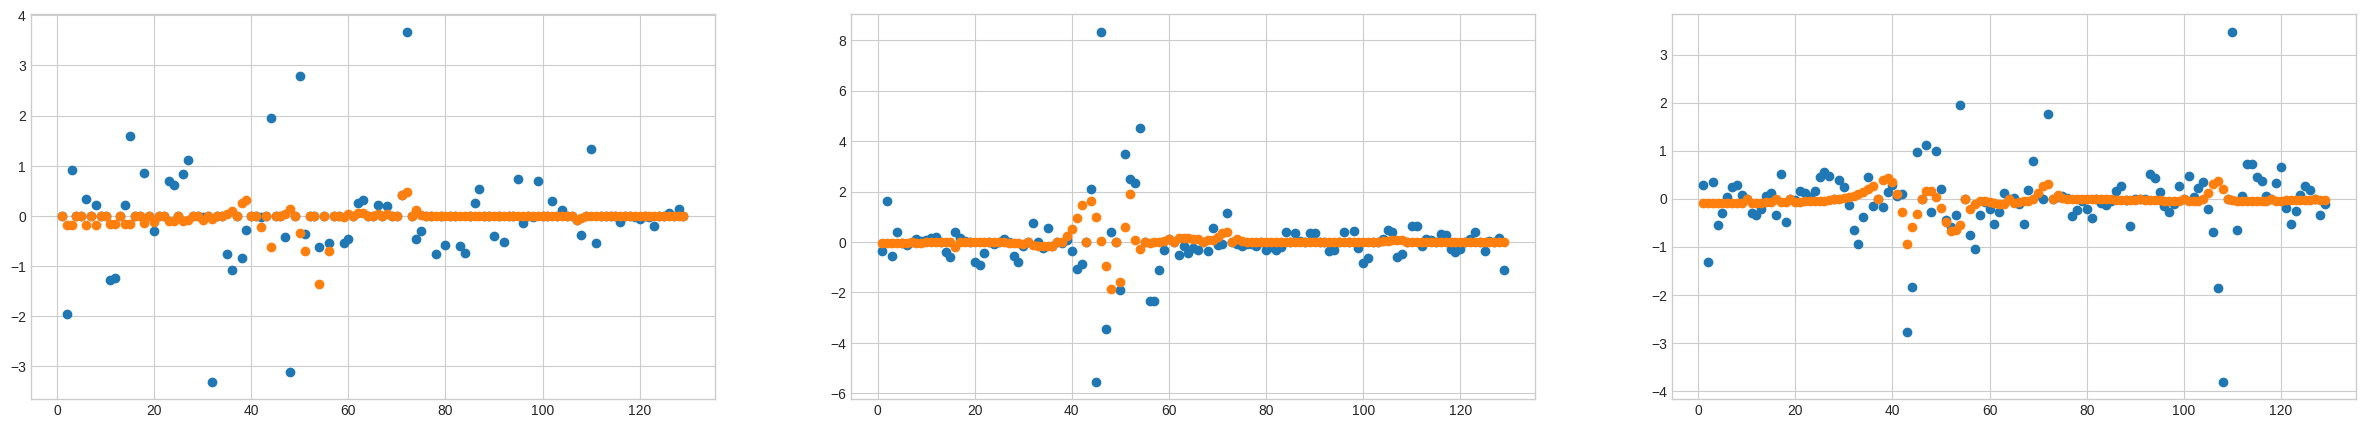

21th additional rbflayer
21th additional RBFlayer 0th epoch loss: 10.167029778117739
21th additional RBFlayer 999th epoch MSE Loss: 9.61094791156837
21th additional RBFlayer 1999th epoch MSE Loss: 9.203147458671
21th additional RBFlayer 2999th epoch MSE Loss: 9.128215237148003
21th additional RBFlayer best loss : 9.128146517520346


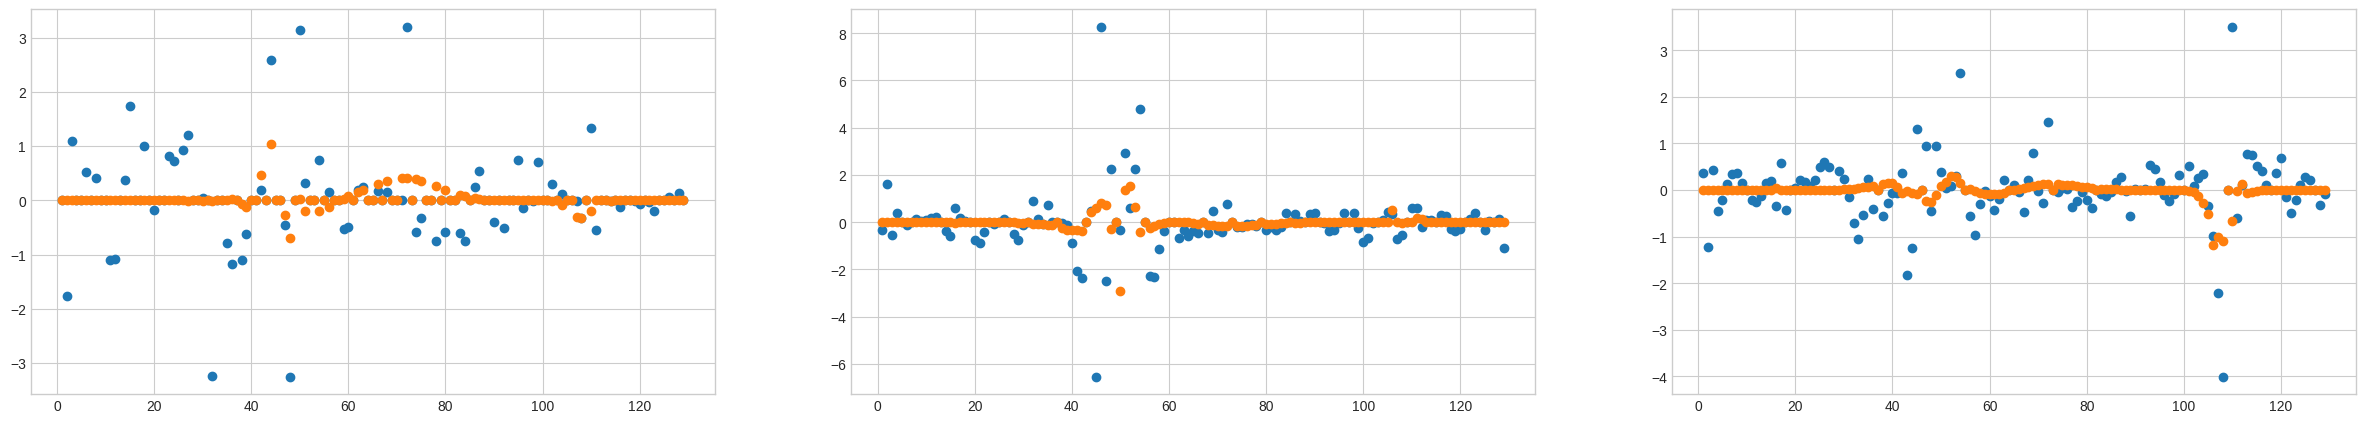

22th additional rbflayer
22th additional RBFlayer 0th epoch loss: 10.08704285845429
22th additional RBFlayer 999th epoch MSE Loss: 9.381307725900365
22th additional RBFlayer 1999th epoch MSE Loss: 9.041583693370097
22th additional RBFlayer 2999th epoch MSE Loss: 9.067920654183789
22th additional RBFlayer best loss : 9.04037653319405


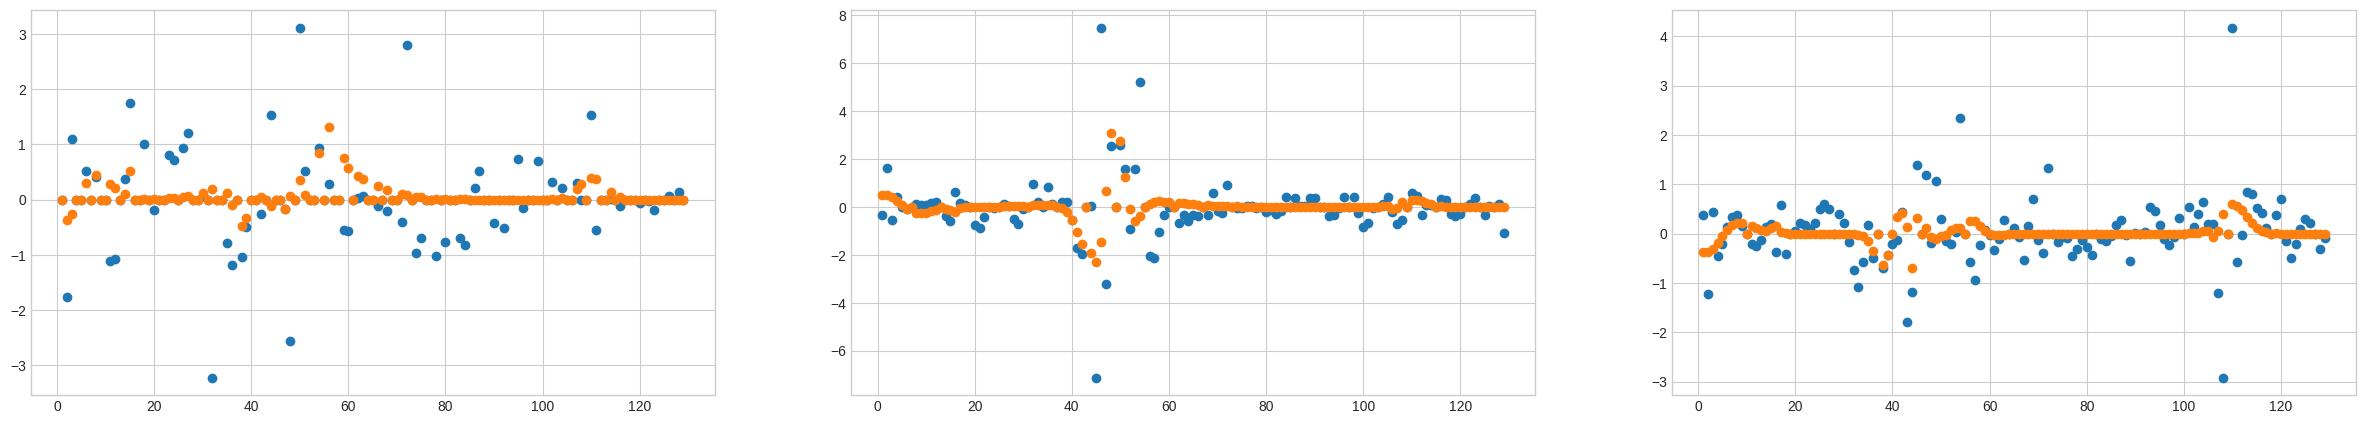

23th additional rbflayer
23th additional RBFlayer 0th epoch loss: 9.832959127825557
23th additional RBFlayer 999th epoch MSE Loss: 9.189200925266006
23th additional RBFlayer 1999th epoch MSE Loss: 9.149660693934452
23th additional RBFlayer 2999th epoch MSE Loss: 8.97862257983679
23th additional RBFlayer best loss : 8.978603294158905
change lr  0.001
----------------------------------------------


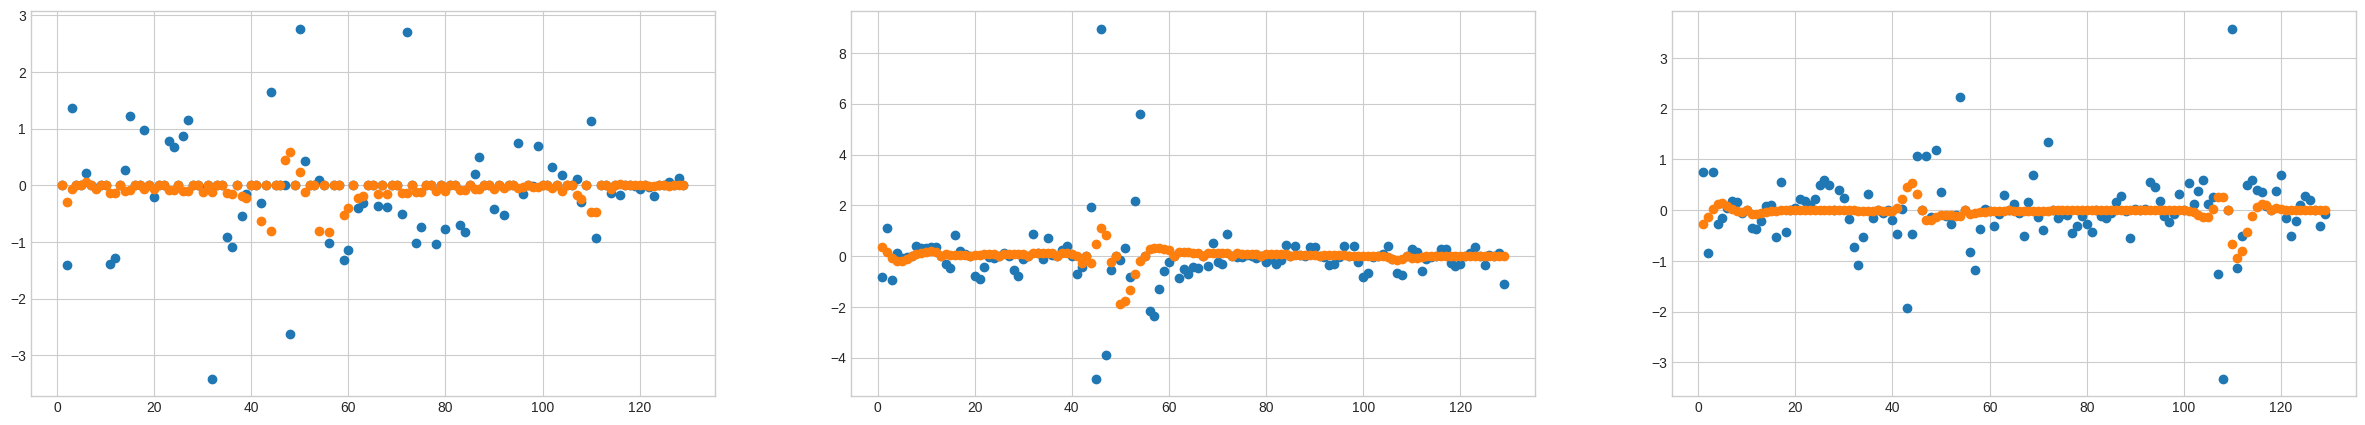

24th additional rbflayer
24th additional RBFlayer 0th epoch loss: 10.89901350369138
24th additional RBFlayer 999th epoch MSE Loss: 8.745888184043777
24th additional RBFlayer 1999th epoch MSE Loss: 8.763679616791519
24th additional RBFlayer 2999th epoch MSE Loss: 8.746024998740129
24th additional RBFlayer best loss : 8.711134946472201


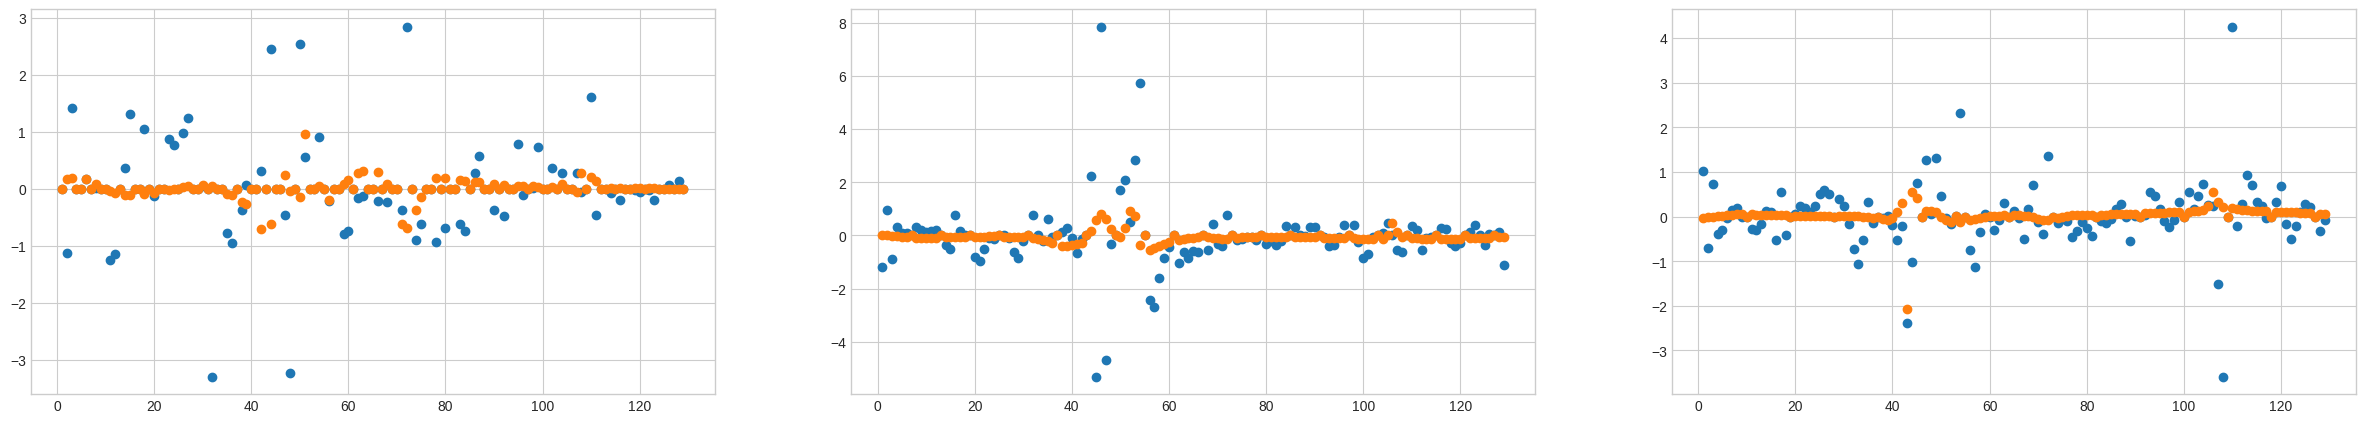

25th additional rbflayer
25th additional RBFlayer 0th epoch loss: 11.913457351461663
25th additional RBFlayer 999th epoch MSE Loss: 8.736232497846203
25th additional RBFlayer 1999th epoch MSE Loss: 8.758231841037889
25th additional RBFlayer 2999th epoch MSE Loss: 9.063722742311766
25th additional RBFlayer best loss : 9.063722742311766


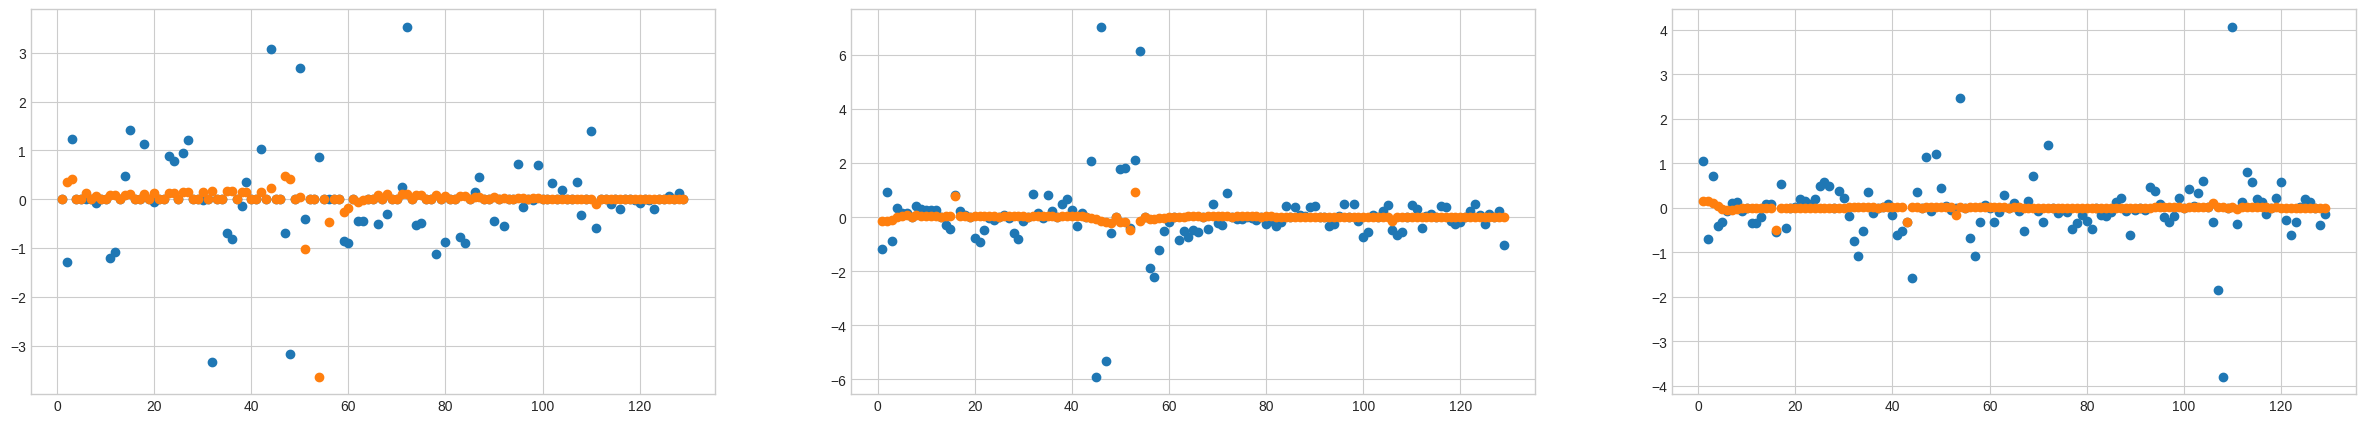

26th additional rbflayer
26th additional RBFlayer 0th epoch loss: 12.54827036208834
26th additional RBFlayer 999th epoch MSE Loss: 13.072655980126427
26th additional RBFlayer 1999th epoch MSE Loss: 12.956048323191862
26th additional RBFlayer 2999th epoch MSE Loss: 12.87630188011665
26th additional RBFlayer best loss : 13.002986157044505


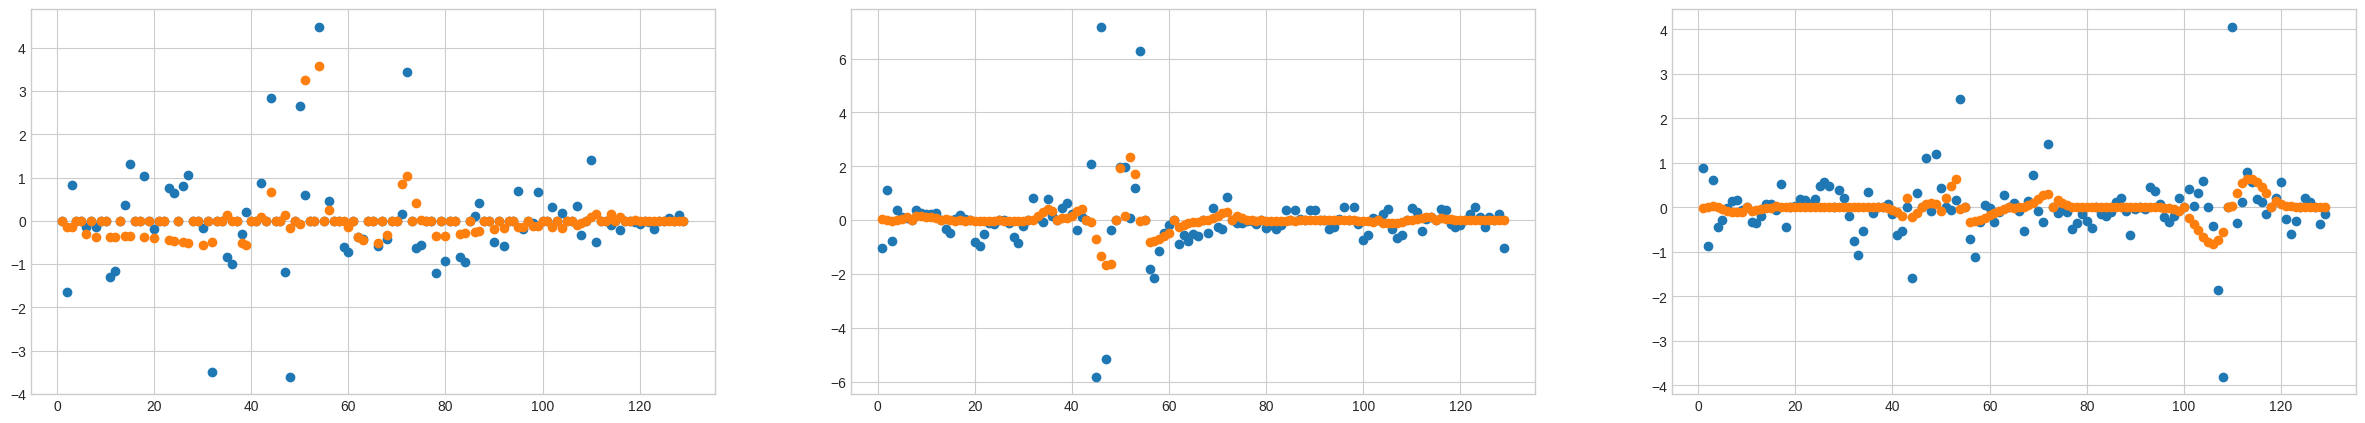

27th additional rbflayer
27th additional RBFlayer 0th epoch loss: 11.883620824600763
27th additional RBFlayer 999th epoch MSE Loss: 11.613499785453739
27th additional RBFlayer 1999th epoch MSE Loss: 11.603955931817941
27th additional RBFlayer 2999th epoch MSE Loss: 11.620806082418168
27th additional RBFlayer best loss : 11.594476612727046


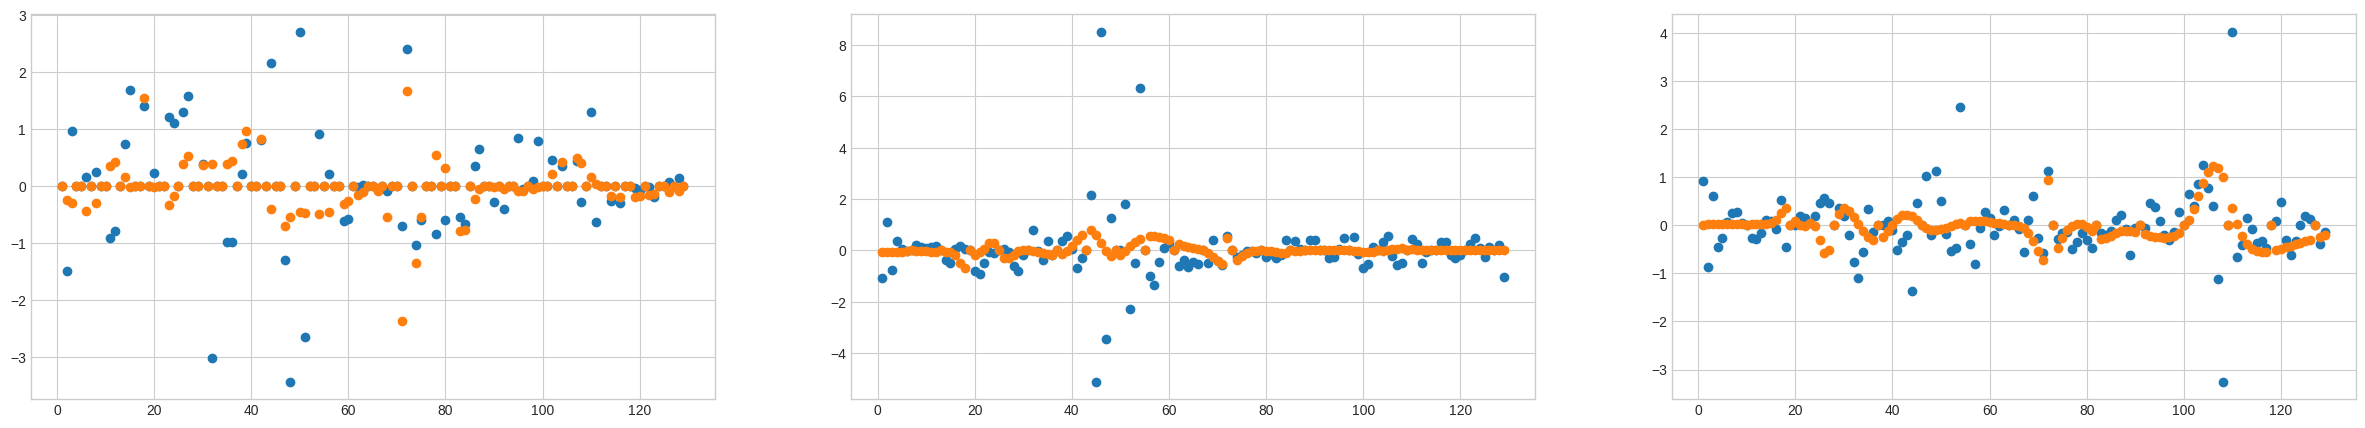

28th additional rbflayer
28th additional RBFlayer 0th epoch loss: 12.223807558368273
28th additional RBFlayer 999th epoch MSE Loss: 11.311589819868205
28th additional RBFlayer 1999th epoch MSE Loss: 11.418797634338727
28th additional RBFlayer 2999th epoch MSE Loss: 11.526417906420951
28th additional RBFlayer best loss : 11.001386676492178


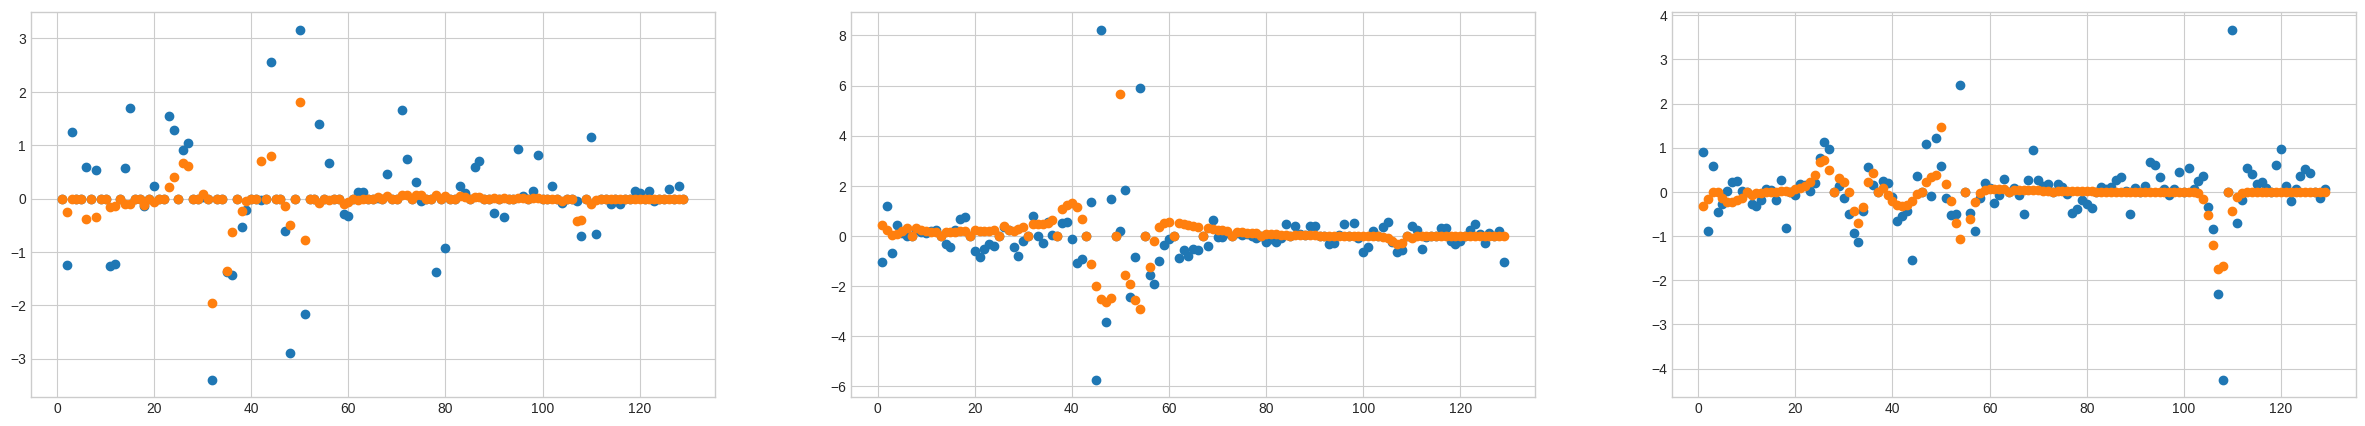

29th additional rbflayer
29th additional RBFlayer 0th epoch loss: 12.178330716445757
29th additional RBFlayer 999th epoch MSE Loss: 10.975478986075505
29th additional RBFlayer 1999th epoch MSE Loss: 11.030892477305489
29th additional RBFlayer 2999th epoch MSE Loss: 11.050876277476128
29th additional RBFlayer best loss : 9.694921447368696


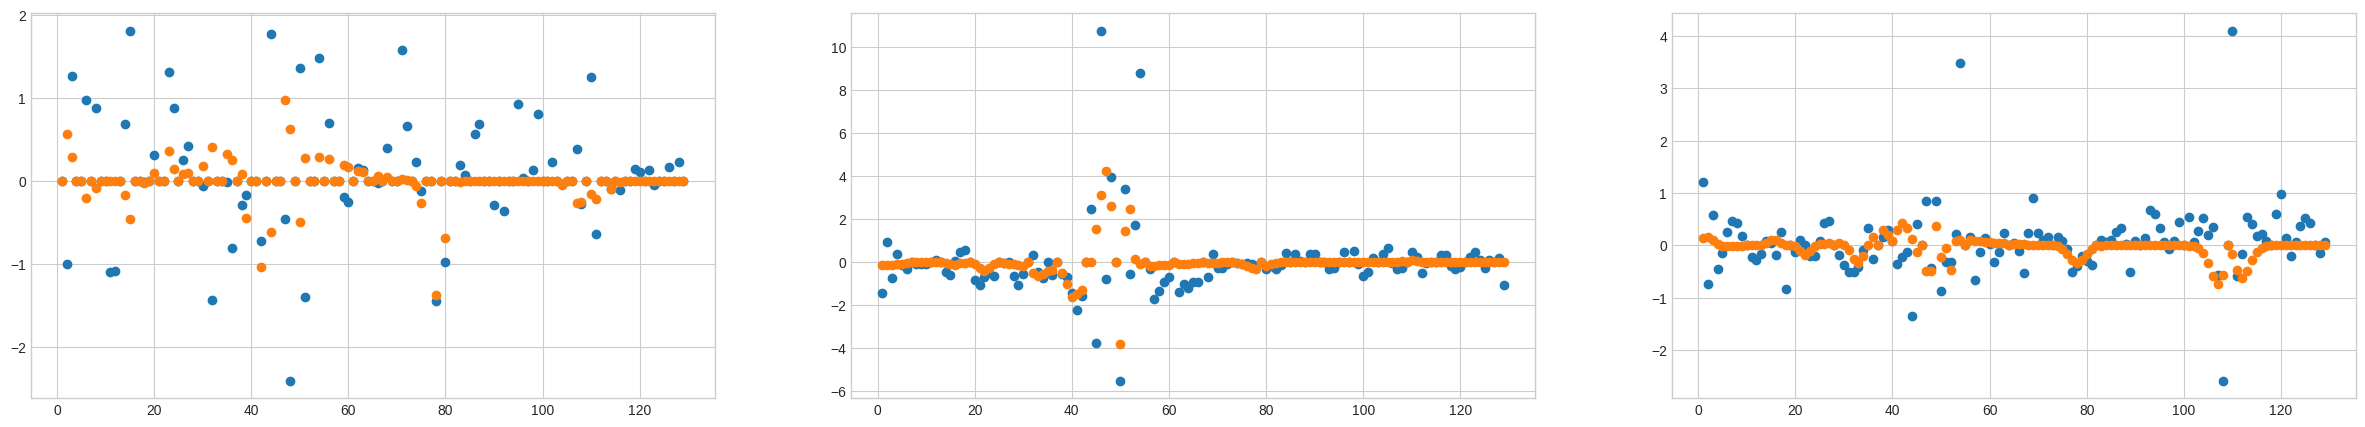

30th additional rbflayer
30th additional RBFlayer 0th epoch loss: 10.210307964763
30th additional RBFlayer 999th epoch MSE Loss: 9.018190999073171
30th additional RBFlayer 1999th epoch MSE Loss: 9.049811311134674
30th additional RBFlayer 2999th epoch MSE Loss: 9.042163079063213
30th additional RBFlayer best loss : 8.946449468692947


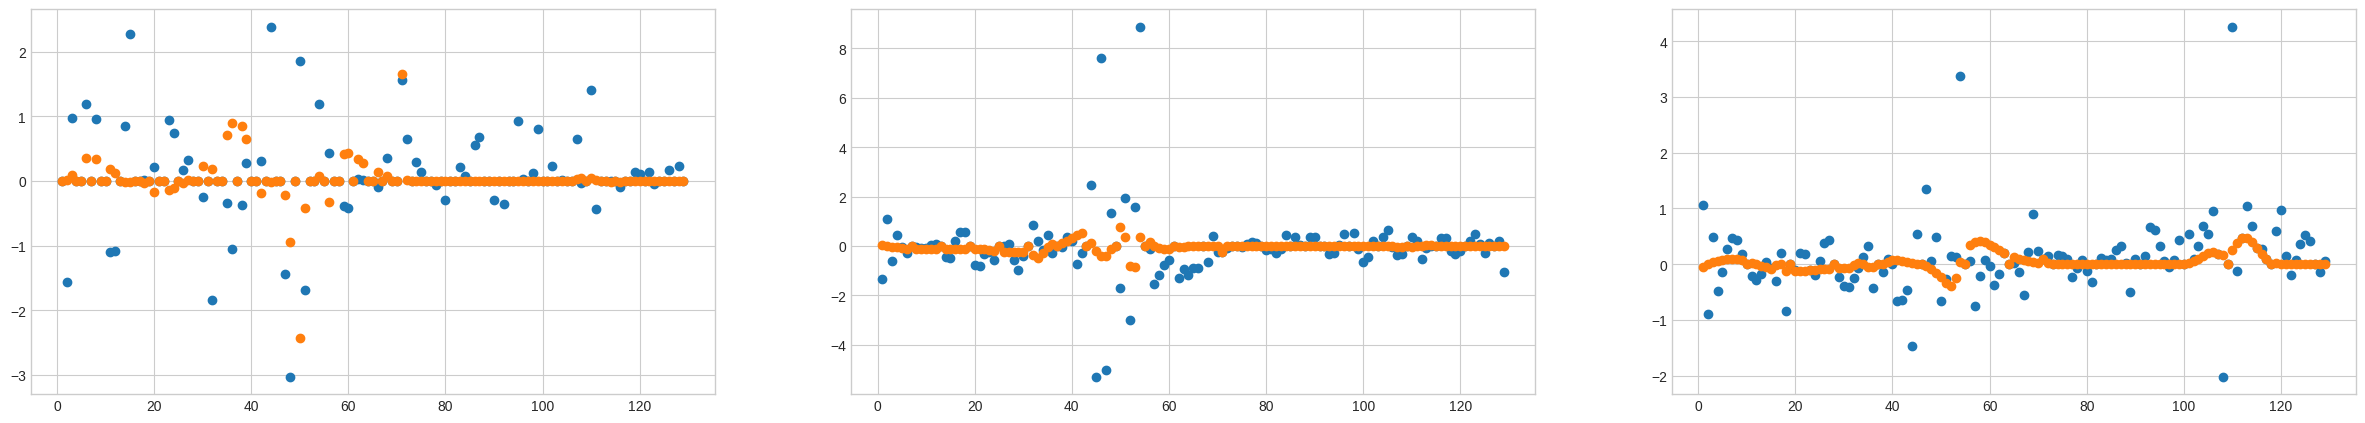

31th additional rbflayer
31th additional RBFlayer 0th epoch loss: 9.749861012798249
31th additional RBFlayer 999th epoch MSE Loss: 8.386784701755387
31th additional RBFlayer 1999th epoch MSE Loss: 8.848483590292942
31th additional RBFlayer 2999th epoch MSE Loss: 8.748089805059914
31th additional RBFlayer best loss : 8.342945613323574


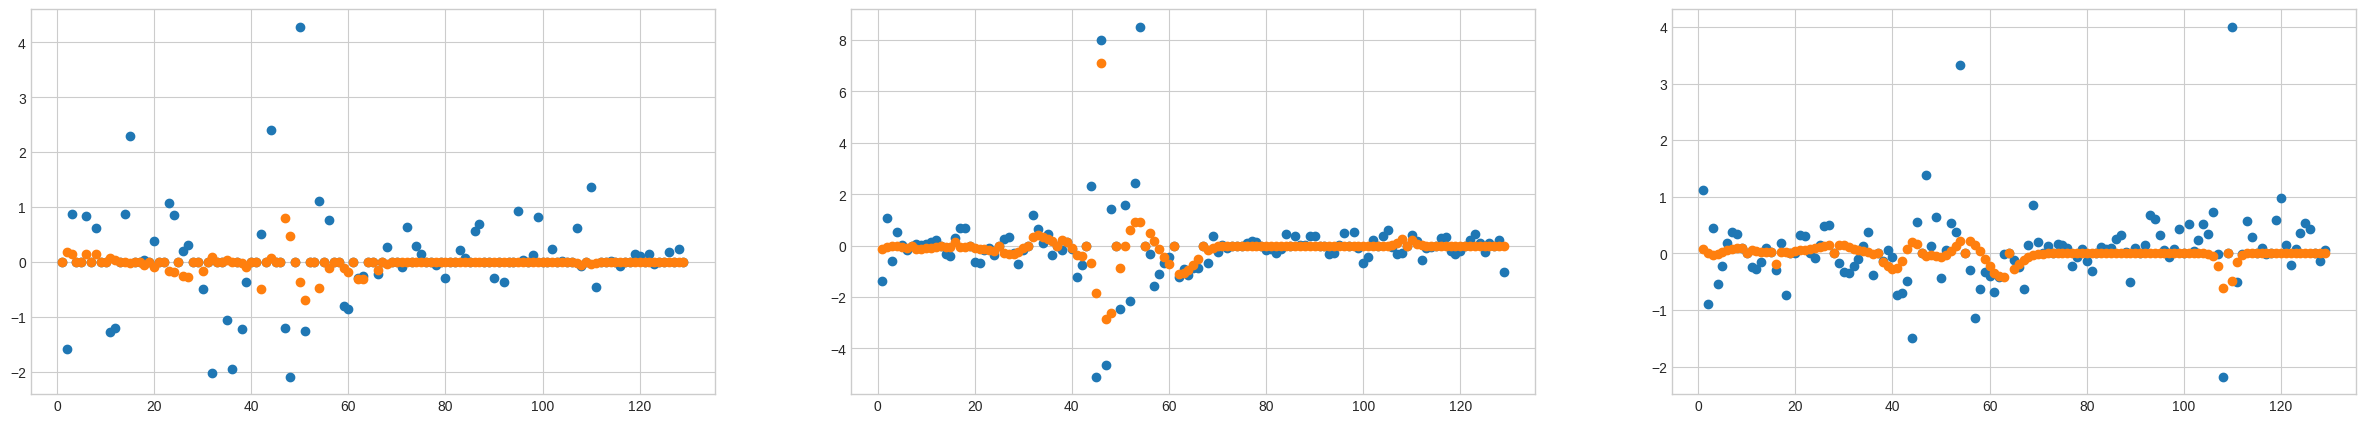

32th additional rbflayer
32th additional RBFlayer 0th epoch loss: 9.947267249895162
32th additional RBFlayer 999th epoch MSE Loss: 8.295824296245506
32th additional RBFlayer 1999th epoch MSE Loss: 8.278429183845764
32th additional RBFlayer 2999th epoch MSE Loss: 8.302088155181014
32th additional RBFlayer best loss : 8.209779231211426


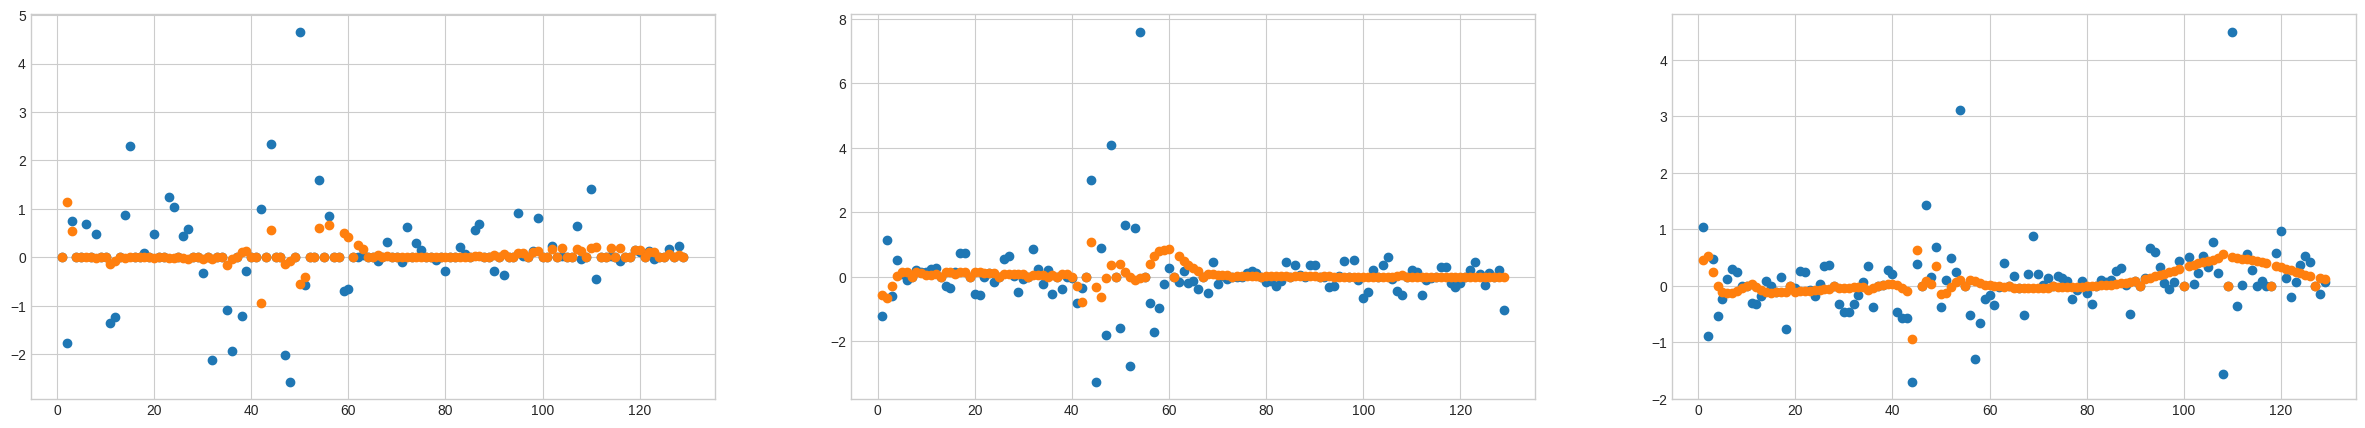

33th additional rbflayer
33th additional RBFlayer 0th epoch loss: 8.788142350994283
33th additional RBFlayer 999th epoch MSE Loss: 7.9641391220542435
33th additional RBFlayer 1999th epoch MSE Loss: 7.945925028083255
33th additional RBFlayer 2999th epoch MSE Loss: 8.11697491065516
33th additional RBFlayer best loss : 7.916634156111767


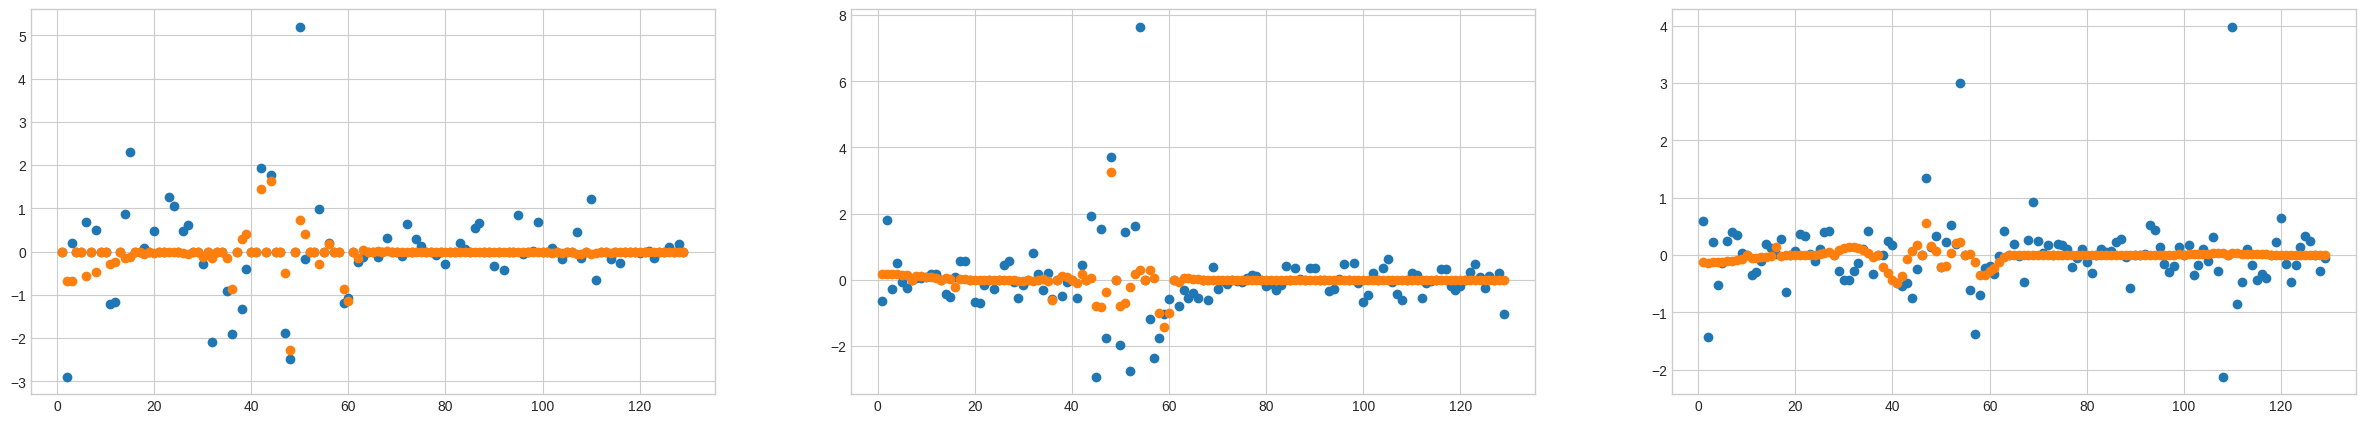

34th additional rbflayer
34th additional RBFlayer 0th epoch loss: 8.416935652582225
34th additional RBFlayer 999th epoch MSE Loss: 7.962430558446829
34th additional RBFlayer 1999th epoch MSE Loss: 7.934736280975109
34th additional RBFlayer 2999th epoch MSE Loss: 7.933720420652293
34th additional RBFlayer best loss : 7.8939071883987015


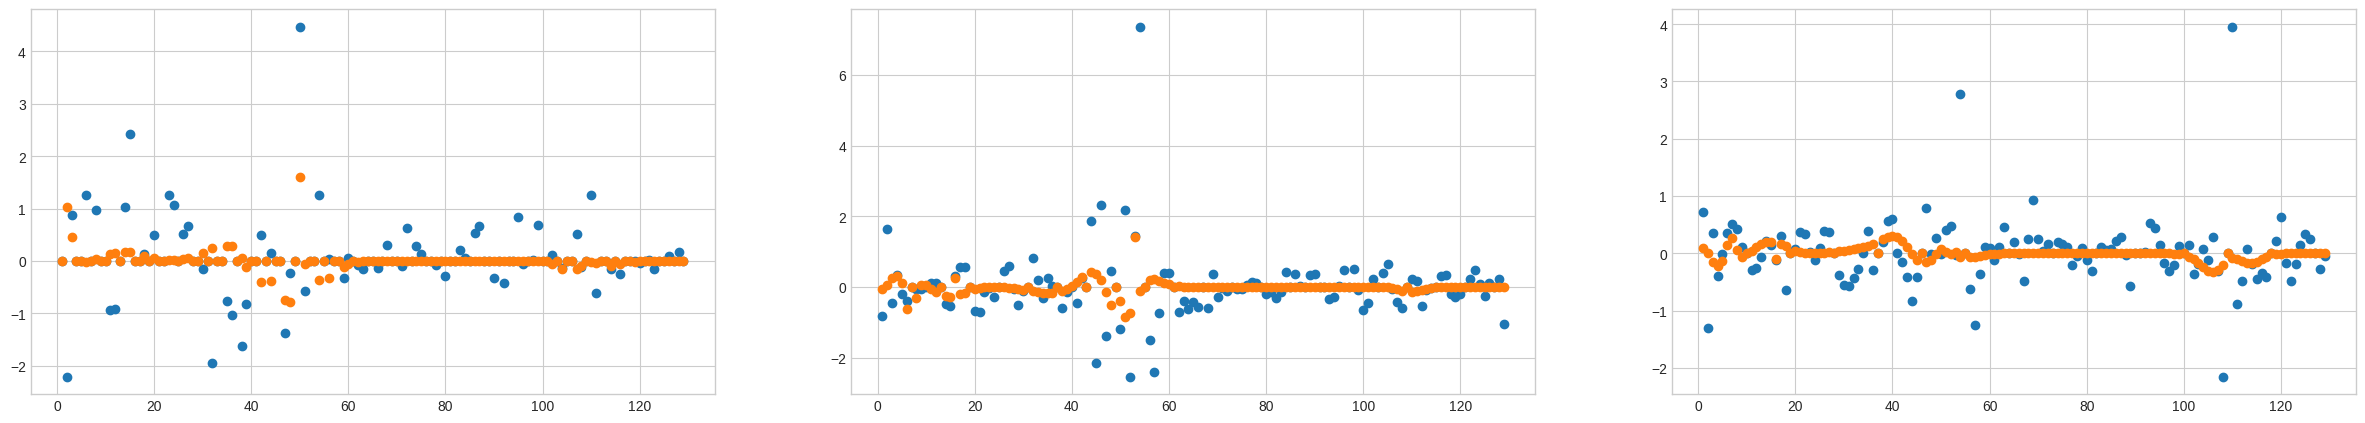

35th additional rbflayer
35th additional RBFlayer 0th epoch loss: 8.579029415519944
35th additional RBFlayer 999th epoch MSE Loss: 7.641849262931555
35th additional RBFlayer 1999th epoch MSE Loss: 7.600767609588737
35th additional RBFlayer 2999th epoch MSE Loss: 7.655430345187202
35th additional RBFlayer best loss : 7.600729758396806


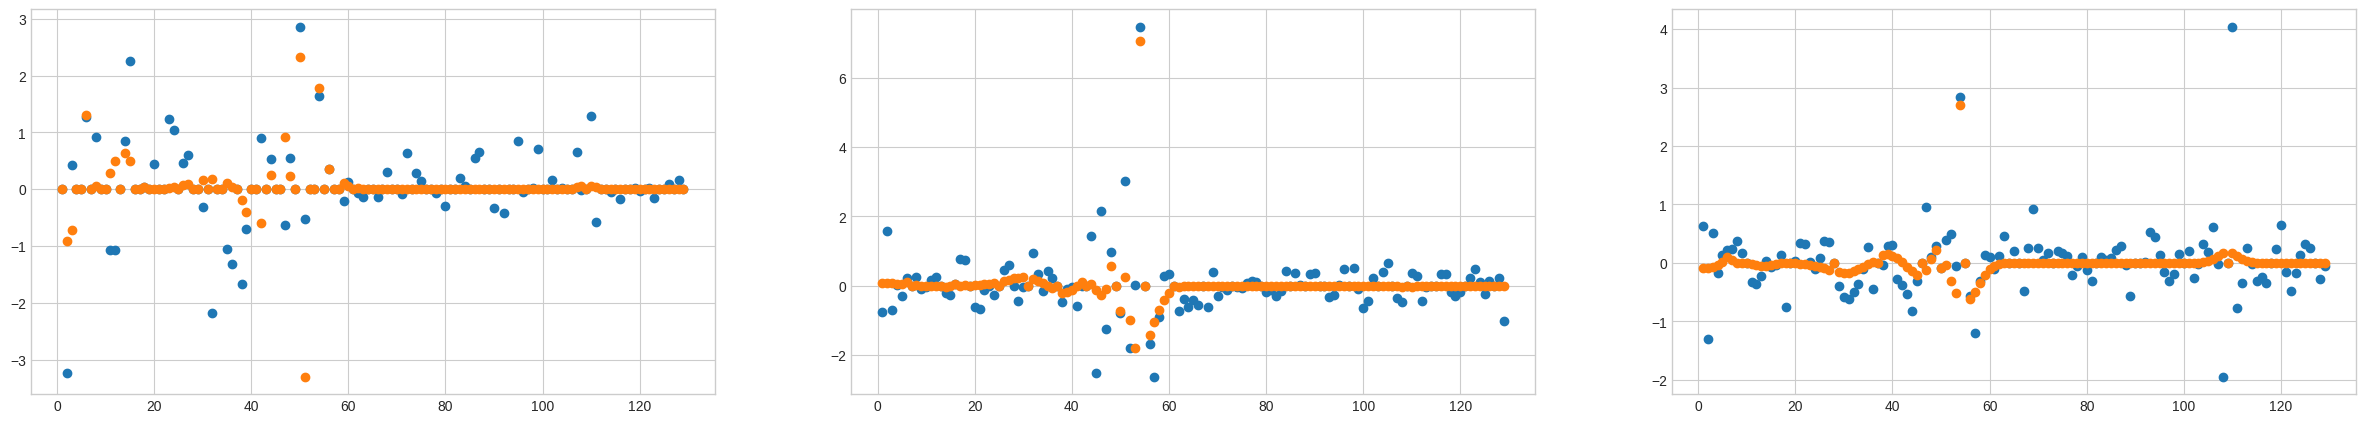

36th additional rbflayer
36th additional RBFlayer 0th epoch loss: 10.250728058293188
36th additional RBFlayer 999th epoch MSE Loss: 7.471702526873225
36th additional RBFlayer 1999th epoch MSE Loss: 7.494292977534032
36th additional RBFlayer 2999th epoch MSE Loss: 7.537496640379247
36th additional RBFlayer best loss : 7.442496494478926


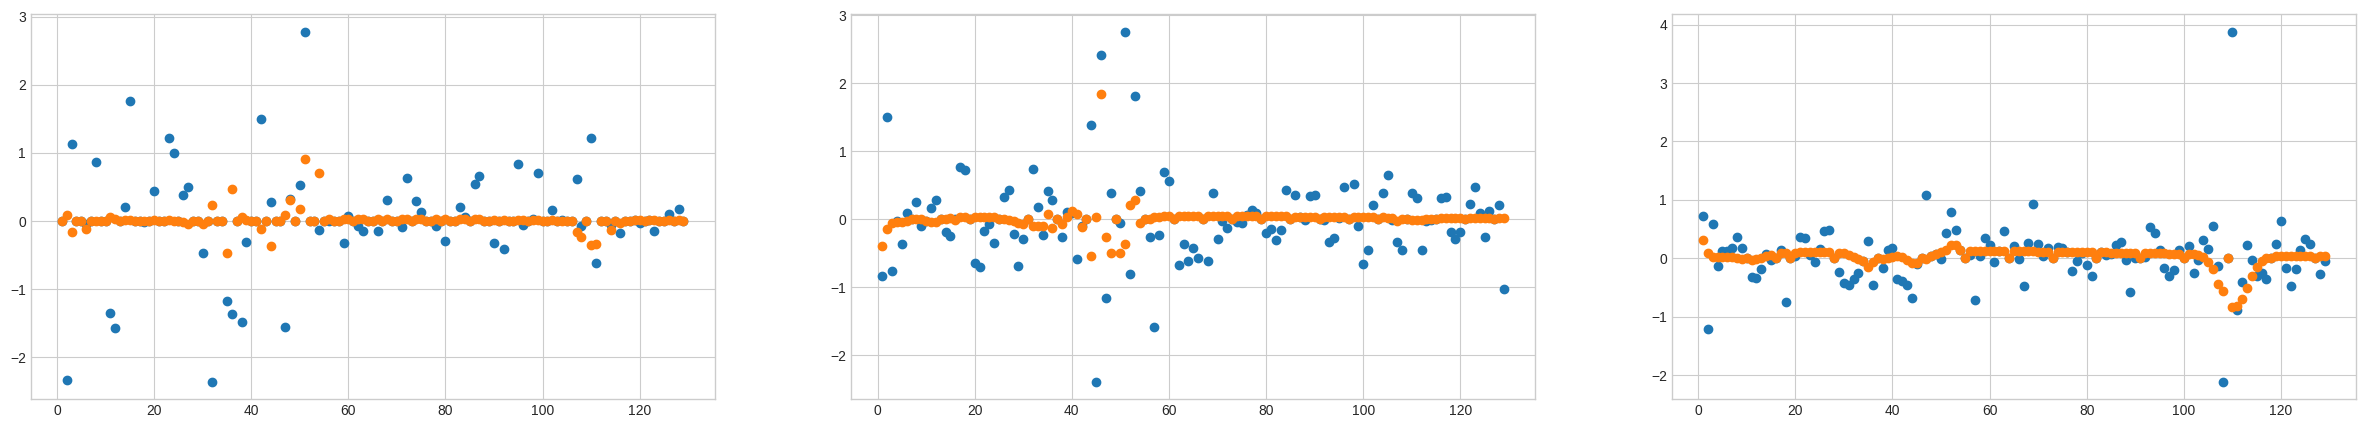

37th additional rbflayer
37th additional RBFlayer 0th epoch loss: 8.217068023691674
37th additional RBFlayer 999th epoch MSE Loss: 7.158610153120106
37th additional RBFlayer 1999th epoch MSE Loss: 7.1672873424227594
37th additional RBFlayer 2999th epoch MSE Loss: 7.166302234335881
37th additional RBFlayer best loss : 7.158301822285859


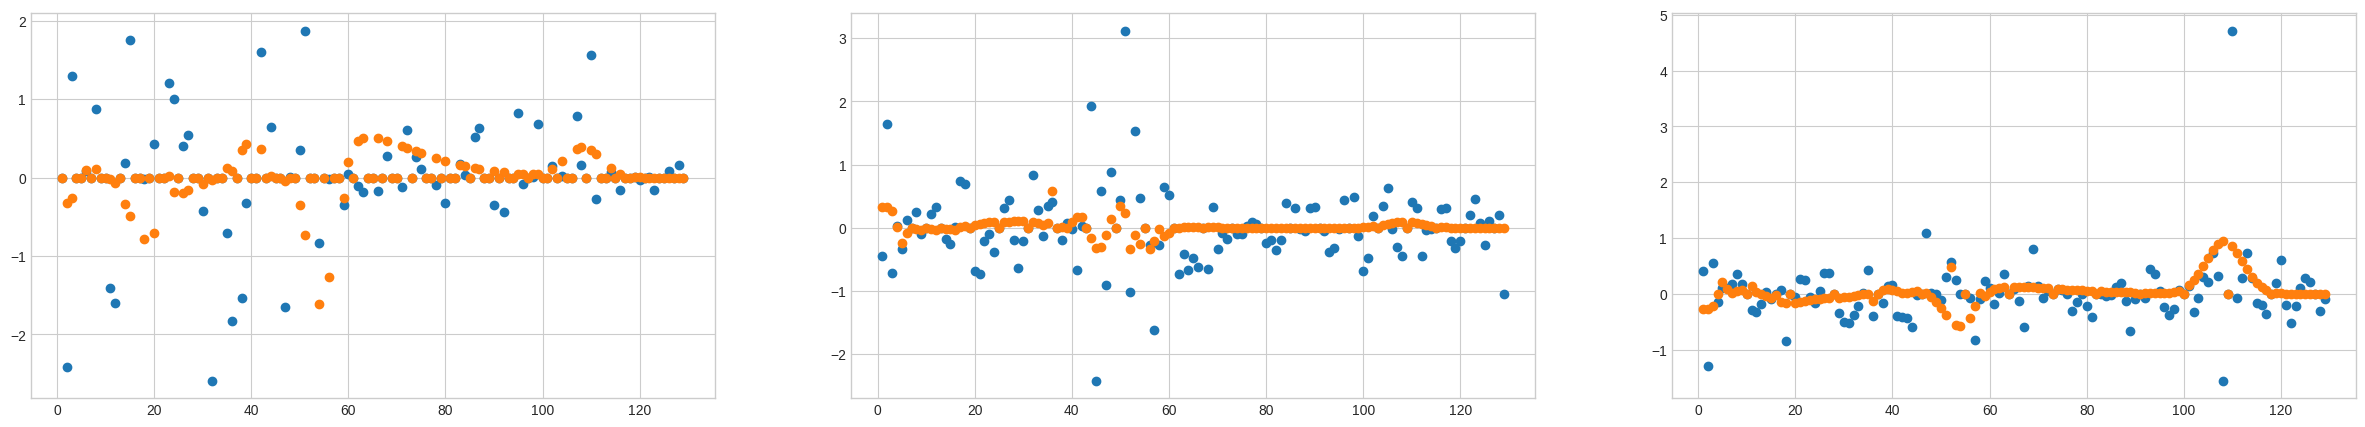

38th additional rbflayer
38th additional RBFlayer 0th epoch loss: 9.889181056601613
38th additional RBFlayer 999th epoch MSE Loss: 7.158842442998068
38th additional RBFlayer 1999th epoch MSE Loss: 7.095649778241402
38th additional RBFlayer 2999th epoch MSE Loss: 7.096047867227371
38th additional RBFlayer best loss : 7.094349411160859


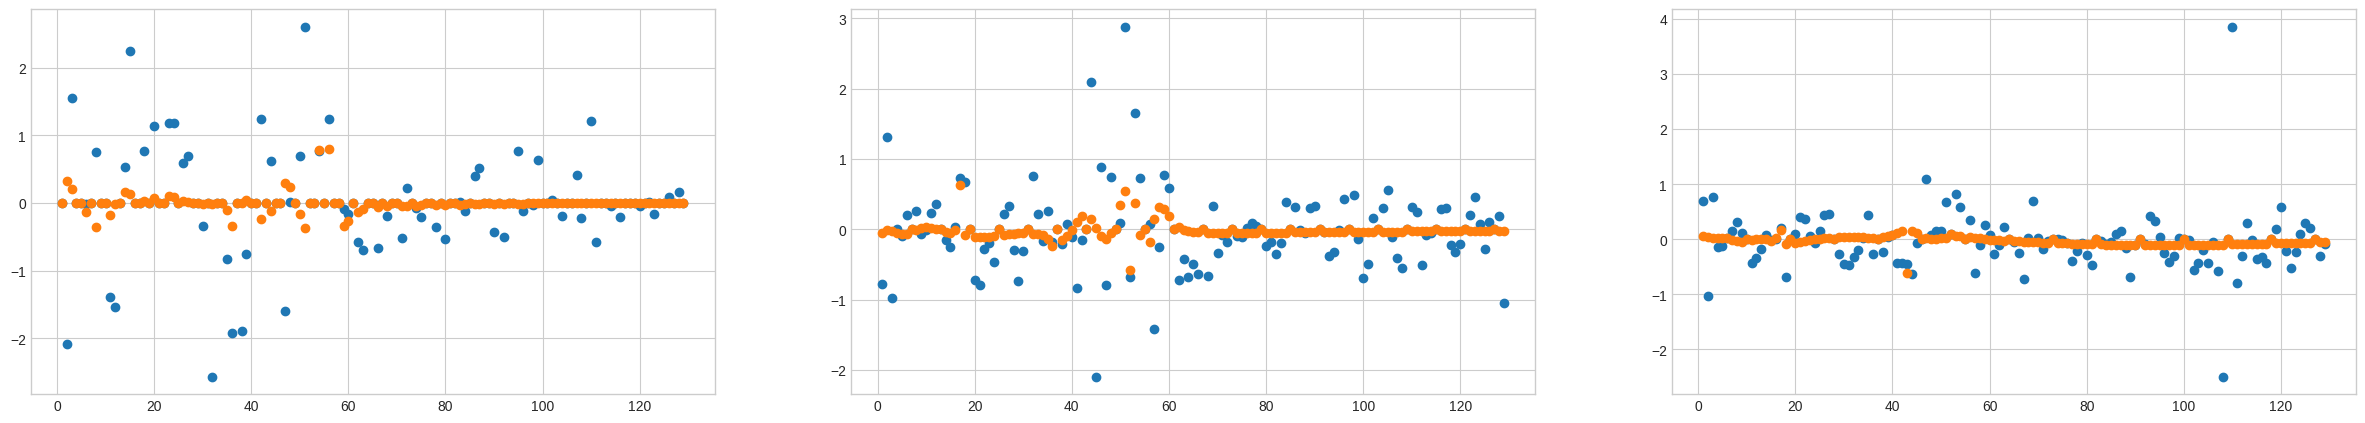

39th additional rbflayer
39th additional RBFlayer 0th epoch loss: 7.713949852879805
39th additional RBFlayer 999th epoch MSE Loss: 7.125536959226674
39th additional RBFlayer 1999th epoch MSE Loss: 7.0804683589988135
39th additional RBFlayer 2999th epoch MSE Loss: 7.080651982368288
39th additional RBFlayer best loss : 7.067860815101997


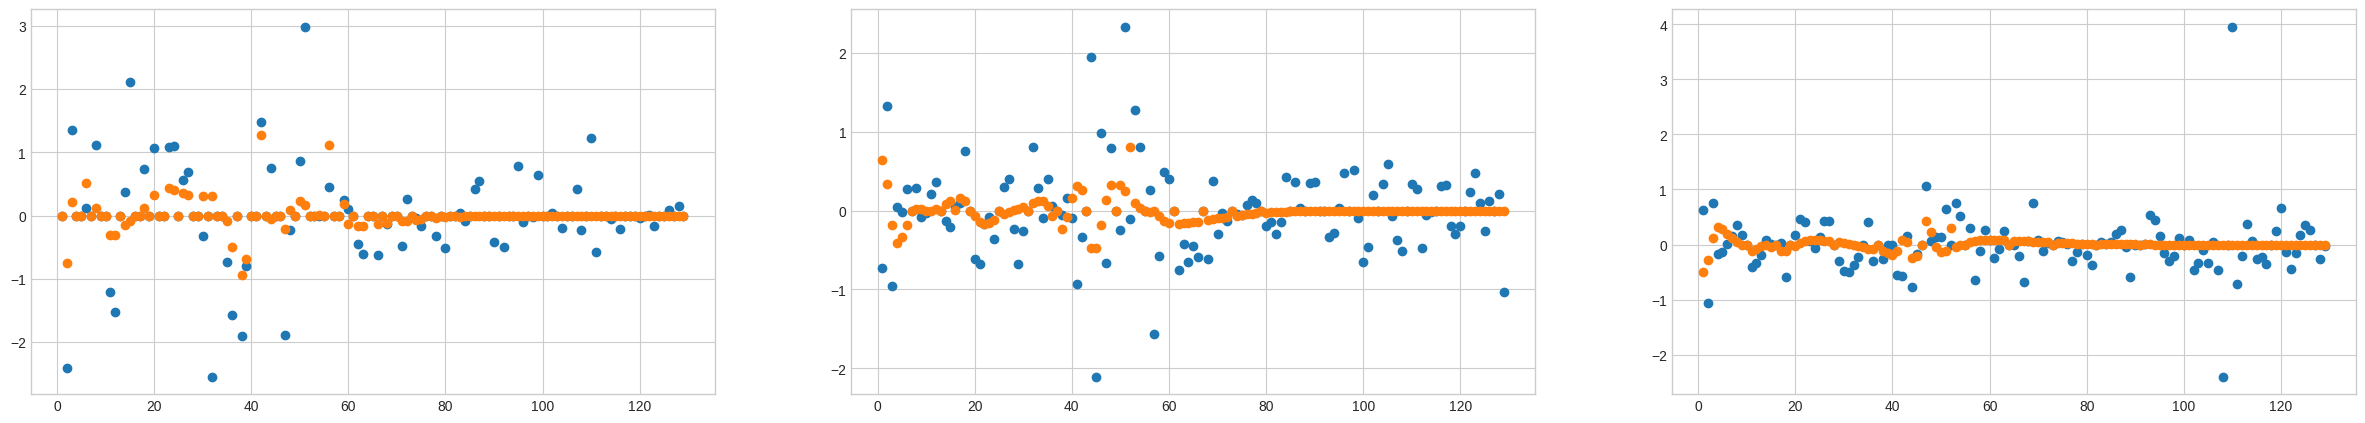

40th additional rbflayer
40th additional RBFlayer 0th epoch loss: 7.969863350920307
40th additional RBFlayer 999th epoch MSE Loss: 7.004754449025118
40th additional RBFlayer 1999th epoch MSE Loss: 6.99907105231029
40th additional RBFlayer 2999th epoch MSE Loss: 6.988116977448992
40th additional RBFlayer best loss : 6.988112224651453


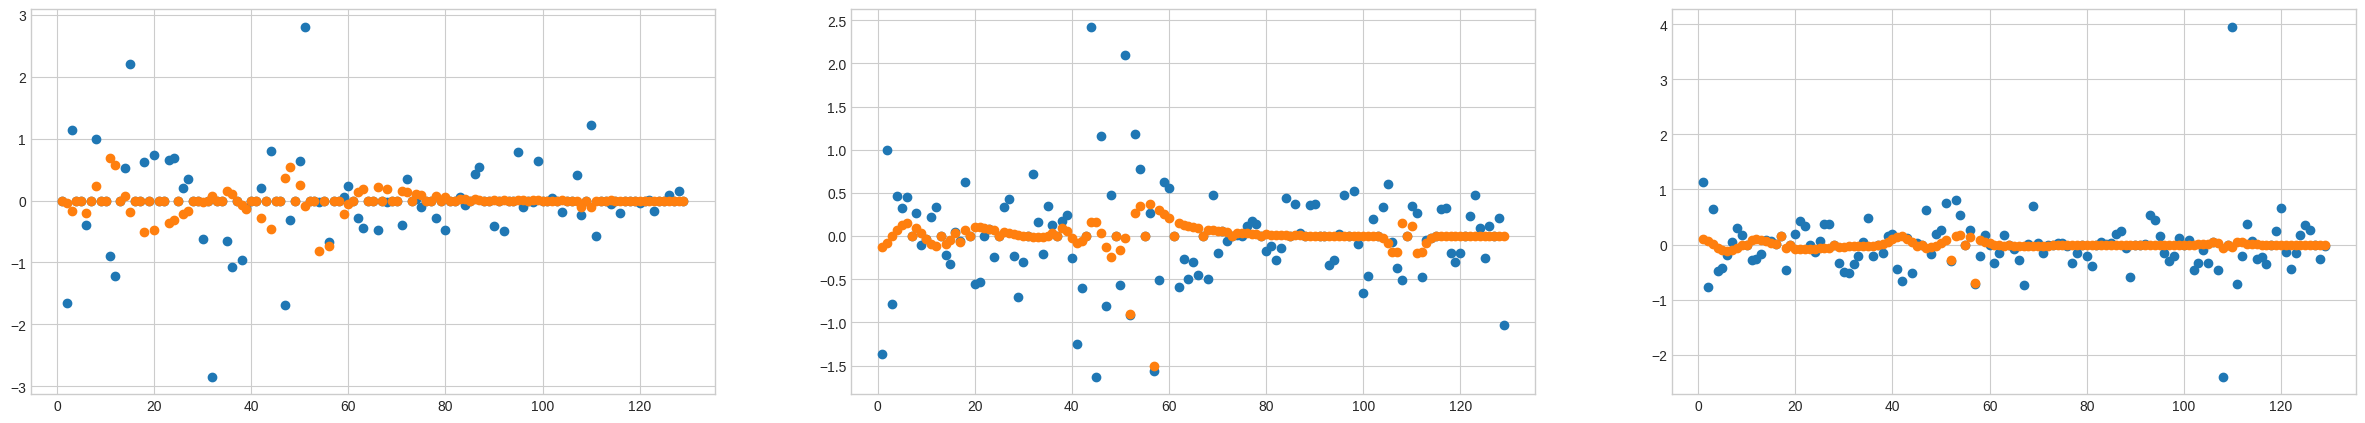

In [11]:
model = MultiRBFnn(3, 20, device)
model.train(input_, target, 3000, 0.0001, 7, 9)

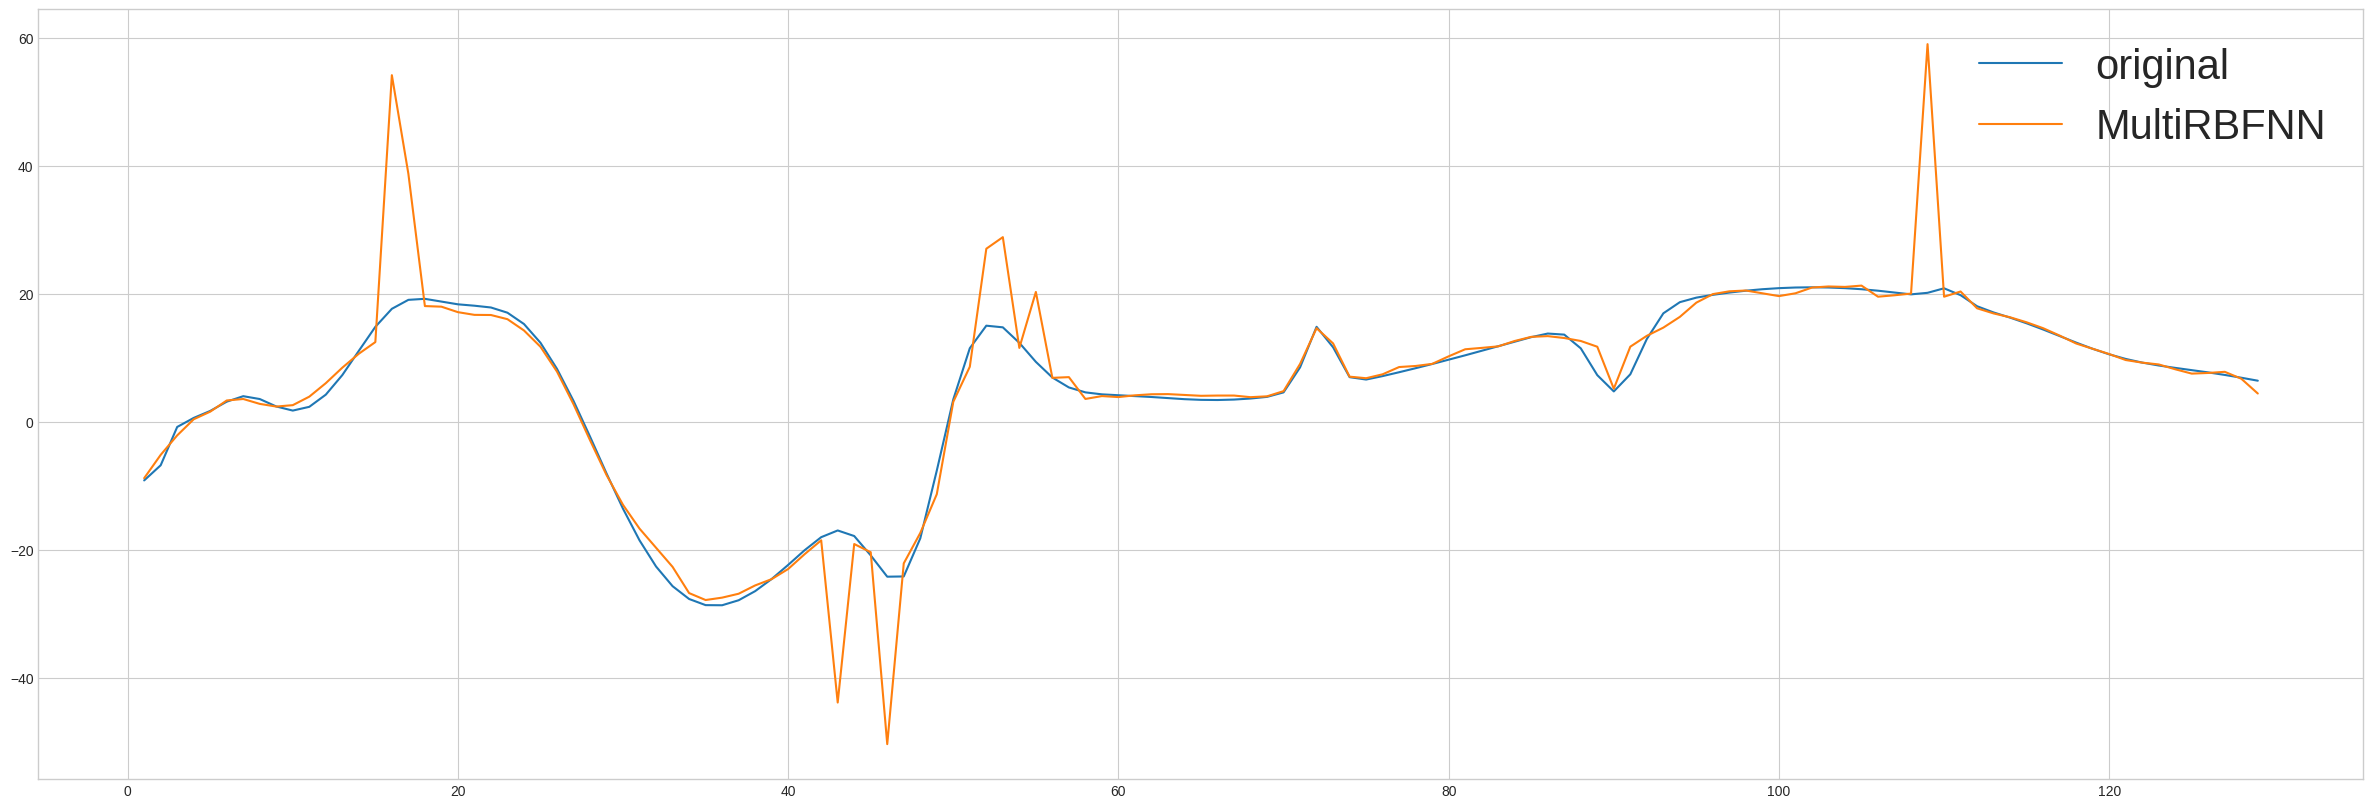

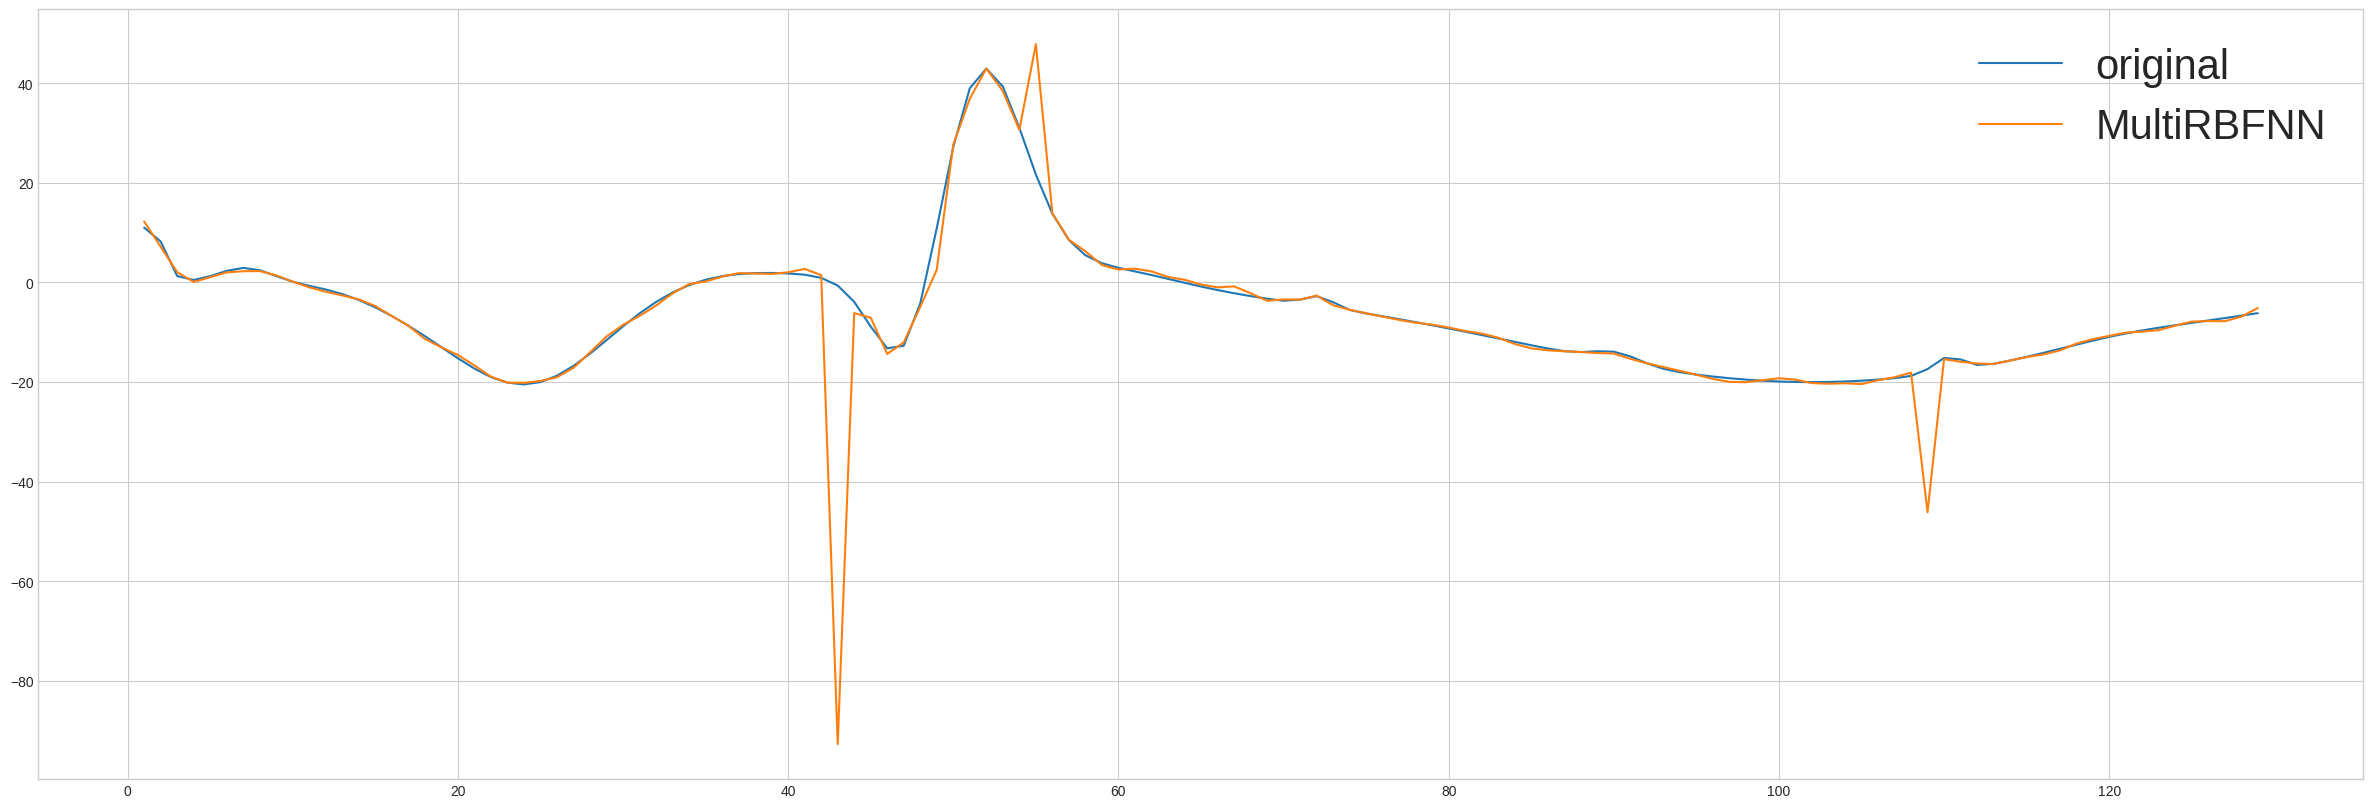

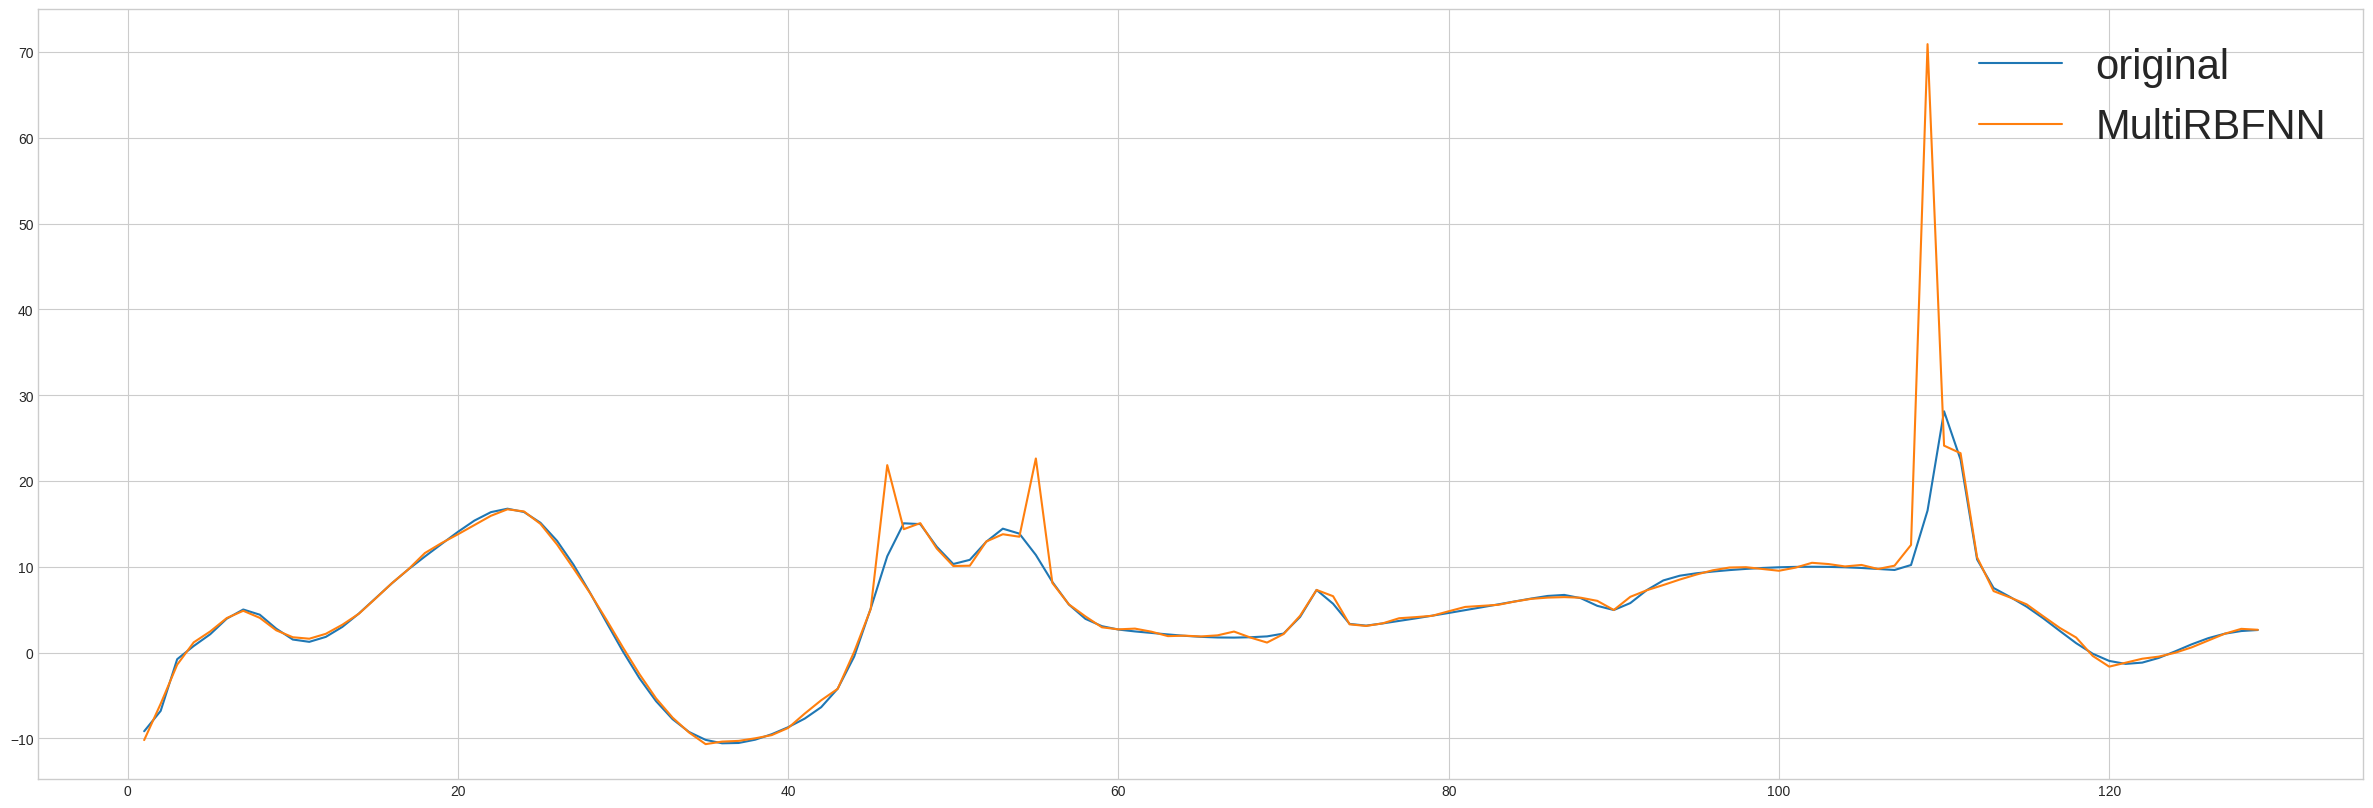

In [12]:
for i in range(3):
    plt.figure(figsize=(30, 10))
    plt.plot(input_.cpu().detach().numpy(), target2[i].cpu().detach().numpy(), label = 'original')
    plt.plot(input_.cpu().detach().numpy(), model.pred(input_)[1][i].cpu().detach().numpy(), label = 'MultiRBFNN')
    plt.legend(fontsize = 30)
    plt.show()

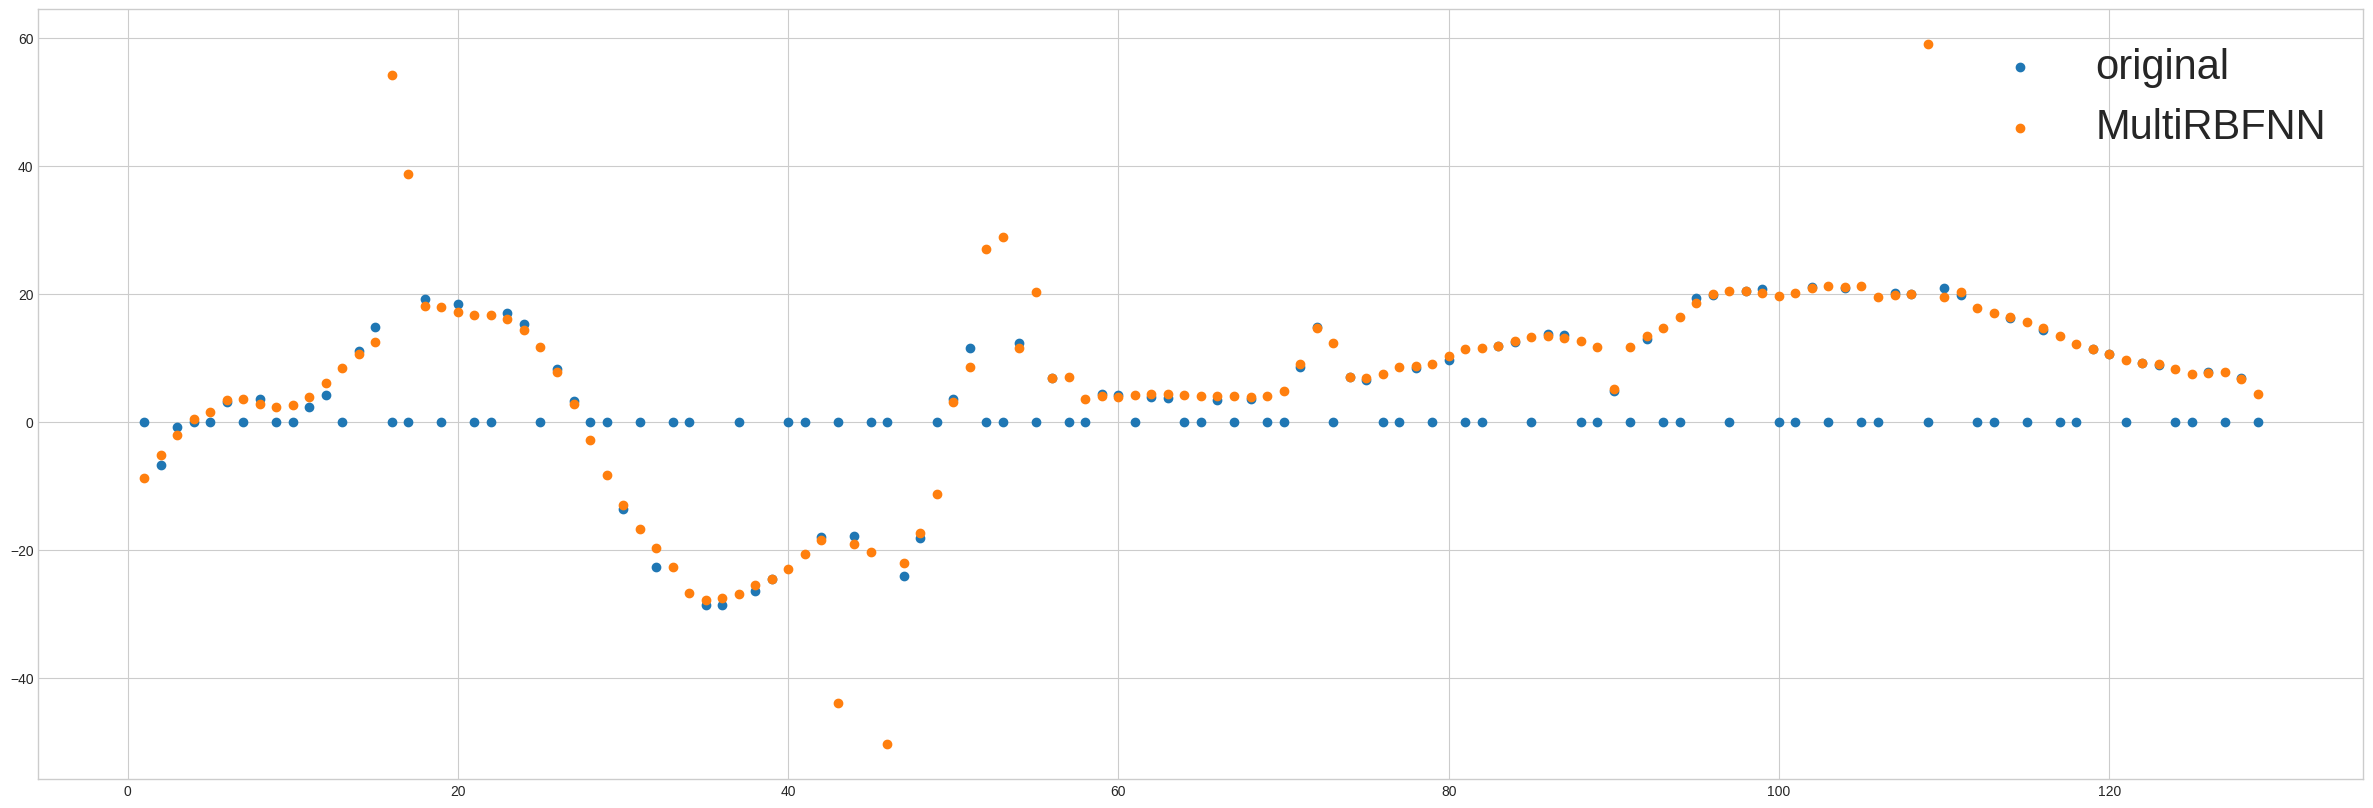

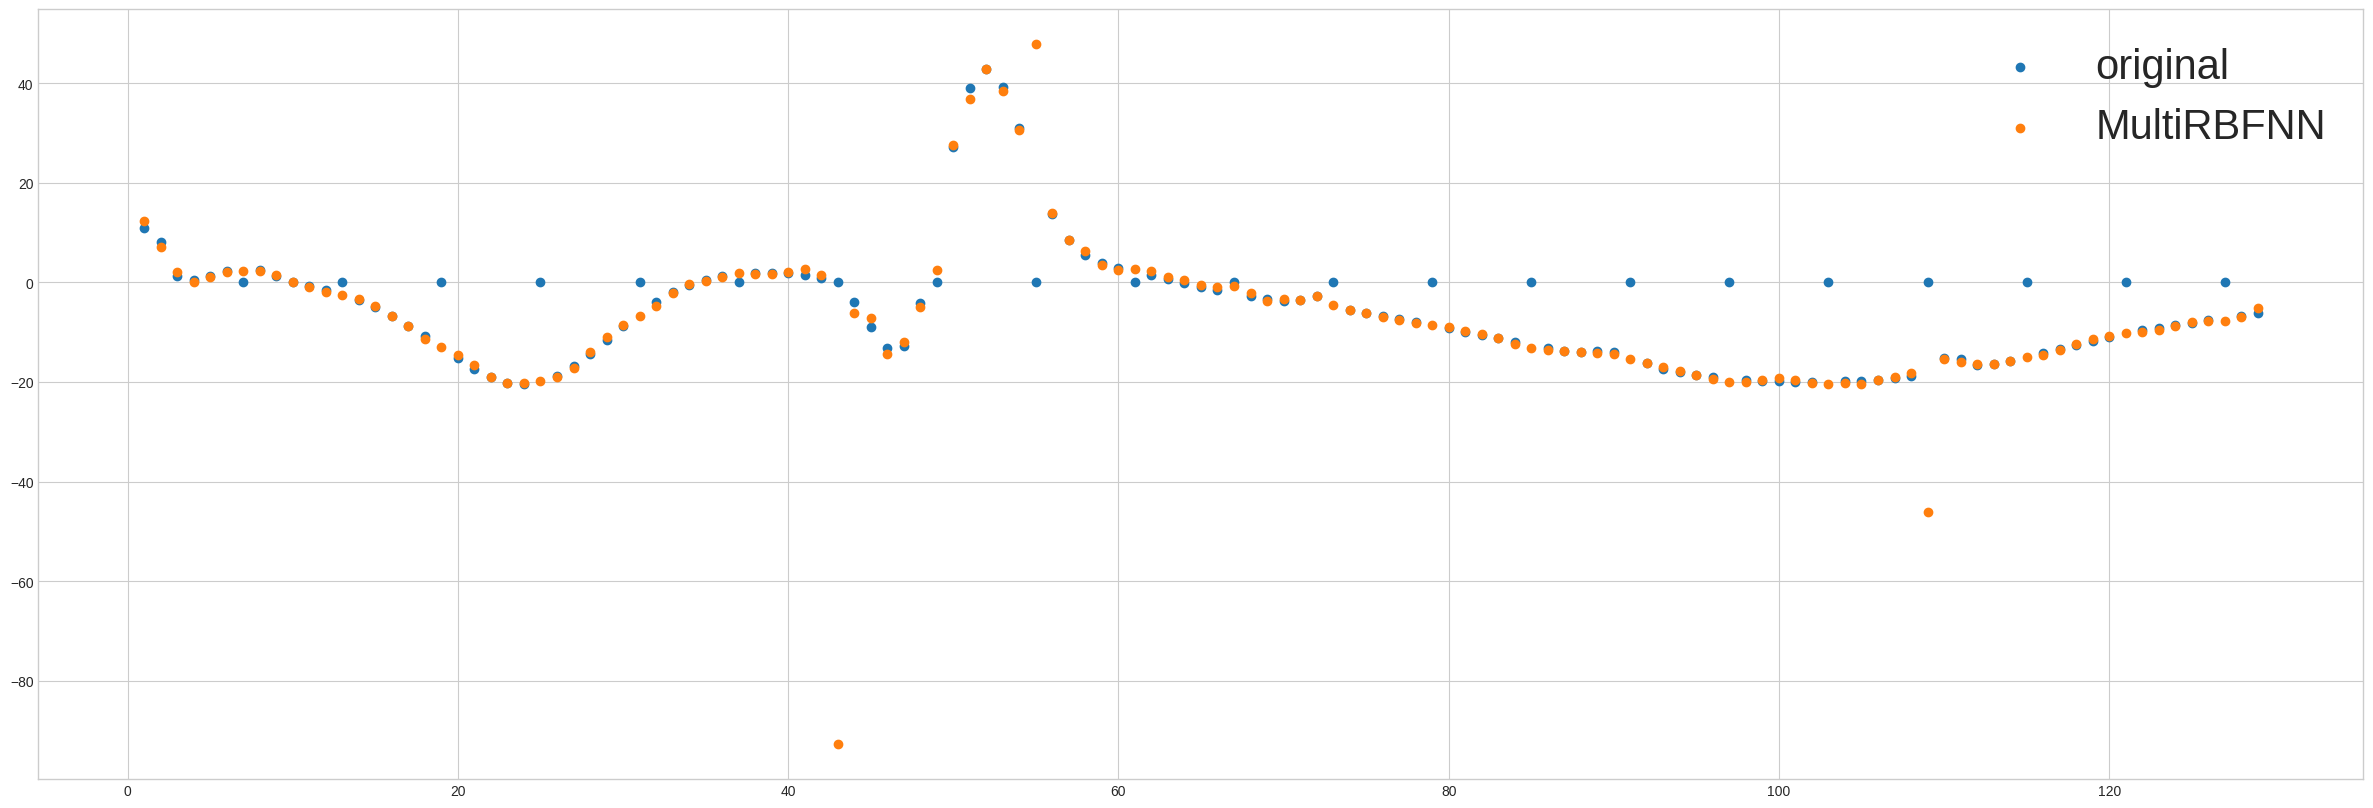

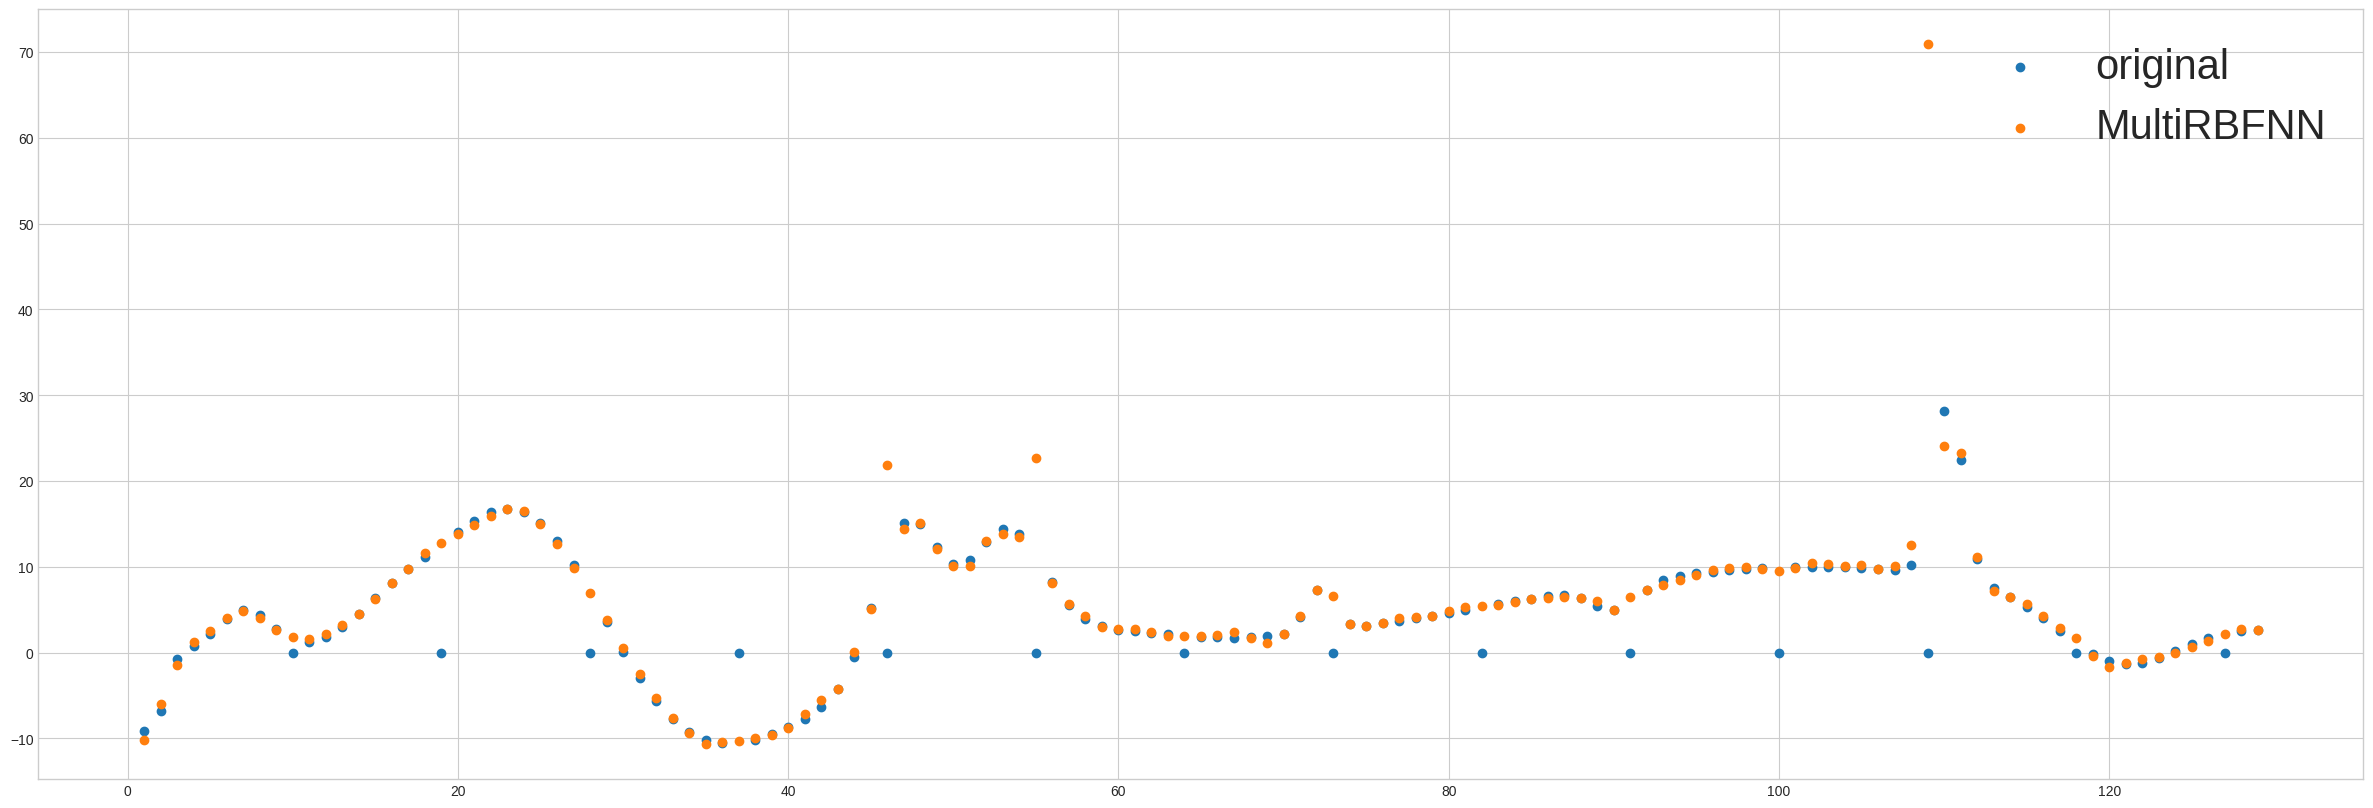

In [28]:
for i in range(3):
    plt.figure(figsize=(30, 10))
    plt.scatter(input_.cpu().detach().numpy(), torch.nan_to_num(target[i]).cpu().detach().numpy(), label = 'original')
    plt.scatter(input_.cpu().detach().numpy(), model.pred(input_)[1][i].cpu().detach().numpy(), label = 'MultiRBFNN')
    plt.legend(fontsize = 30)
    plt.show()

In [13]:
missing_index = torch.where(target.isnan(), 1.0, 0.0).to(torch.float64)

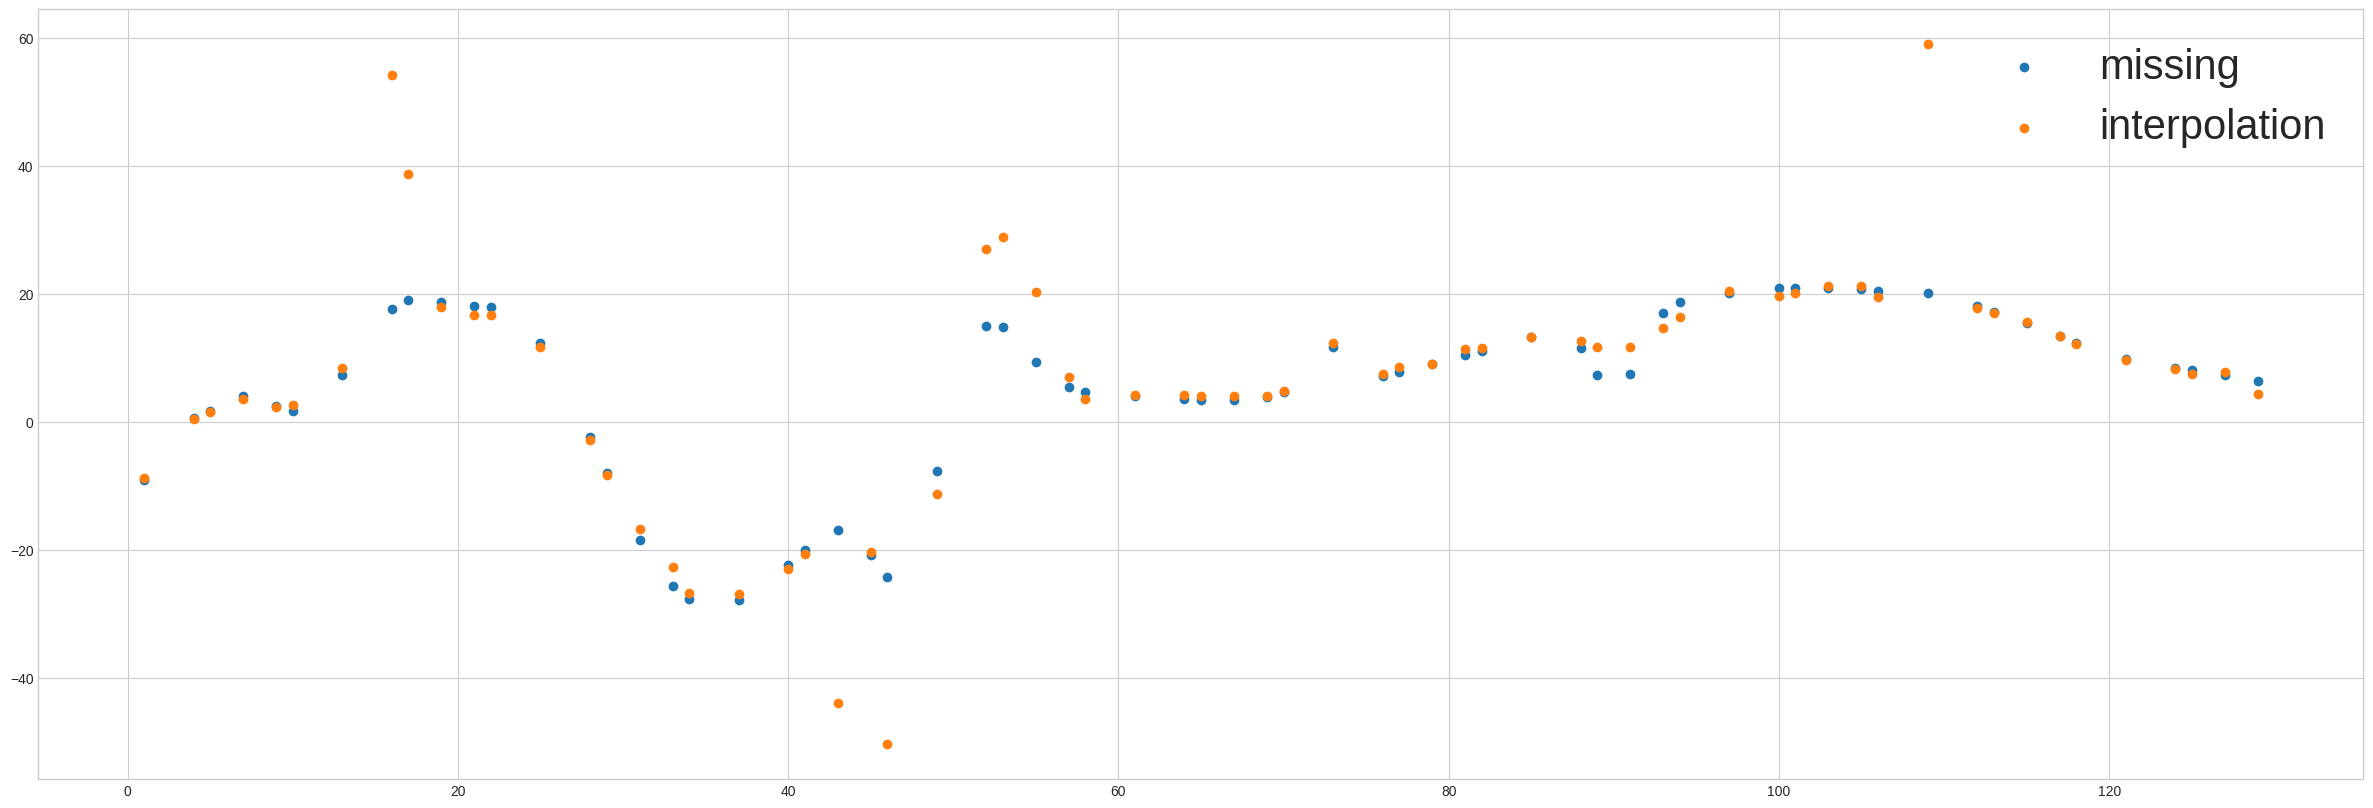

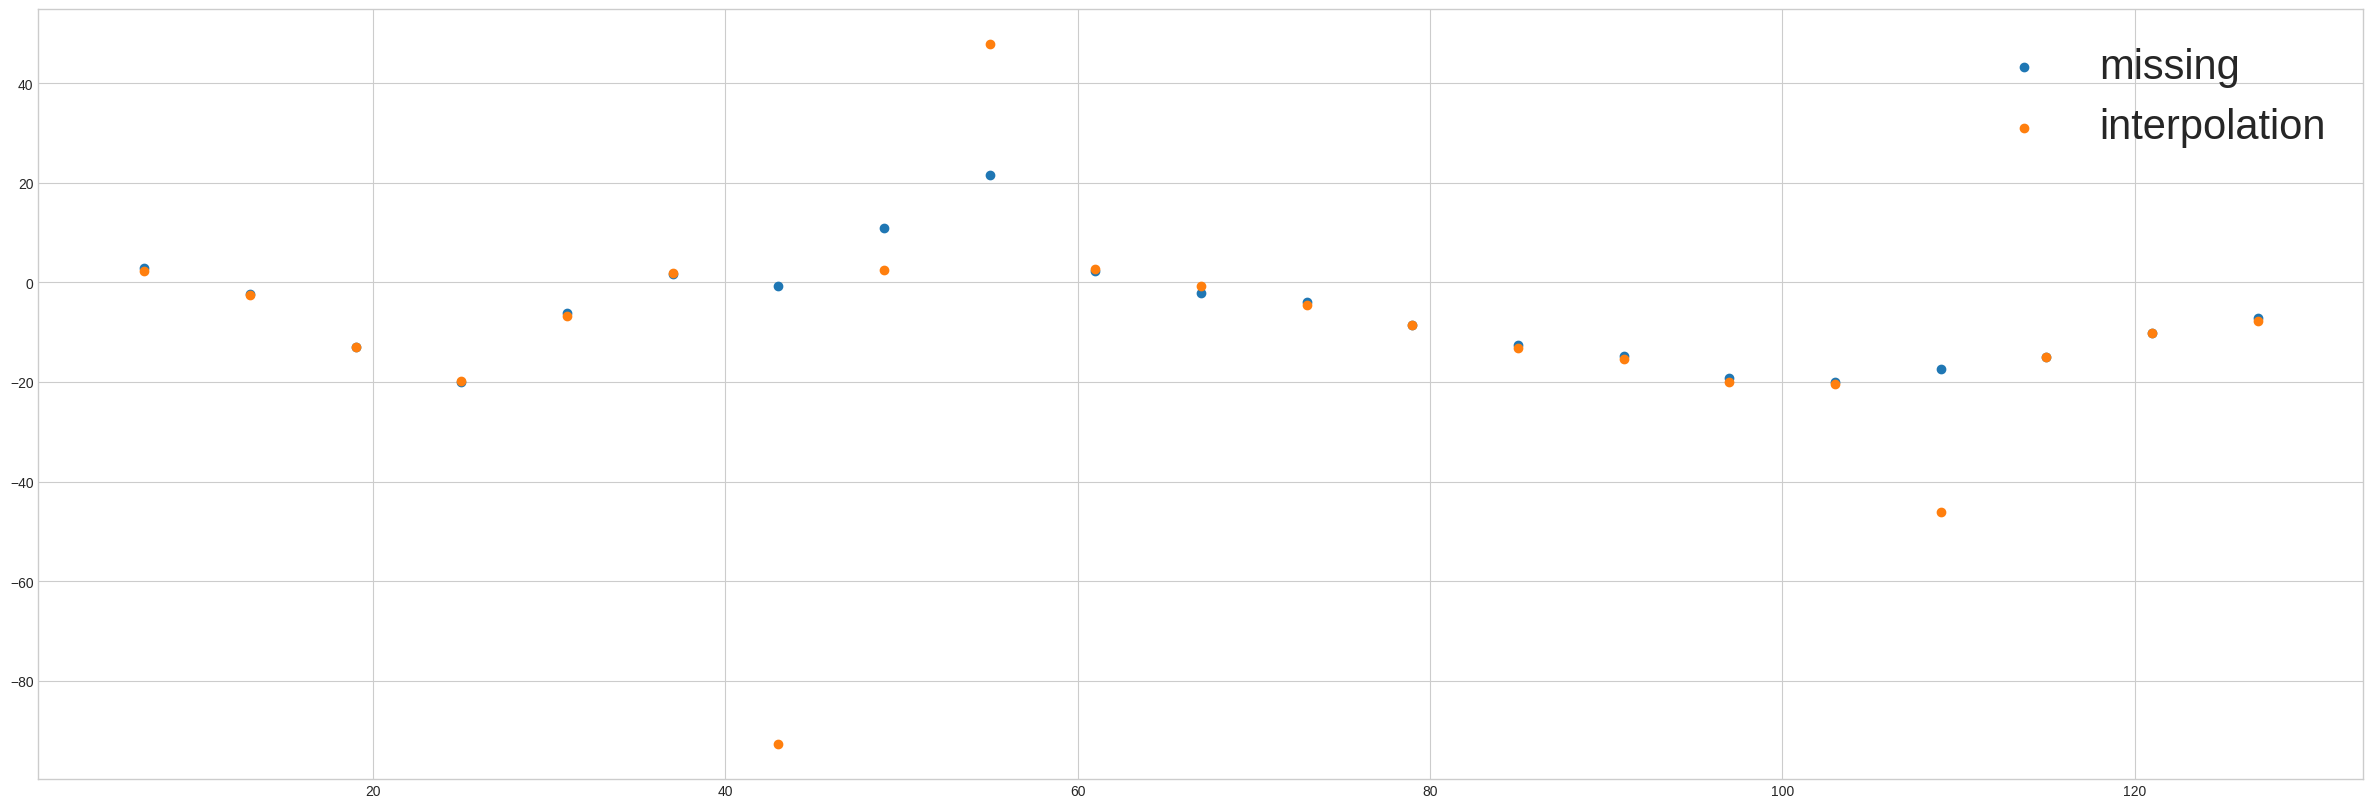

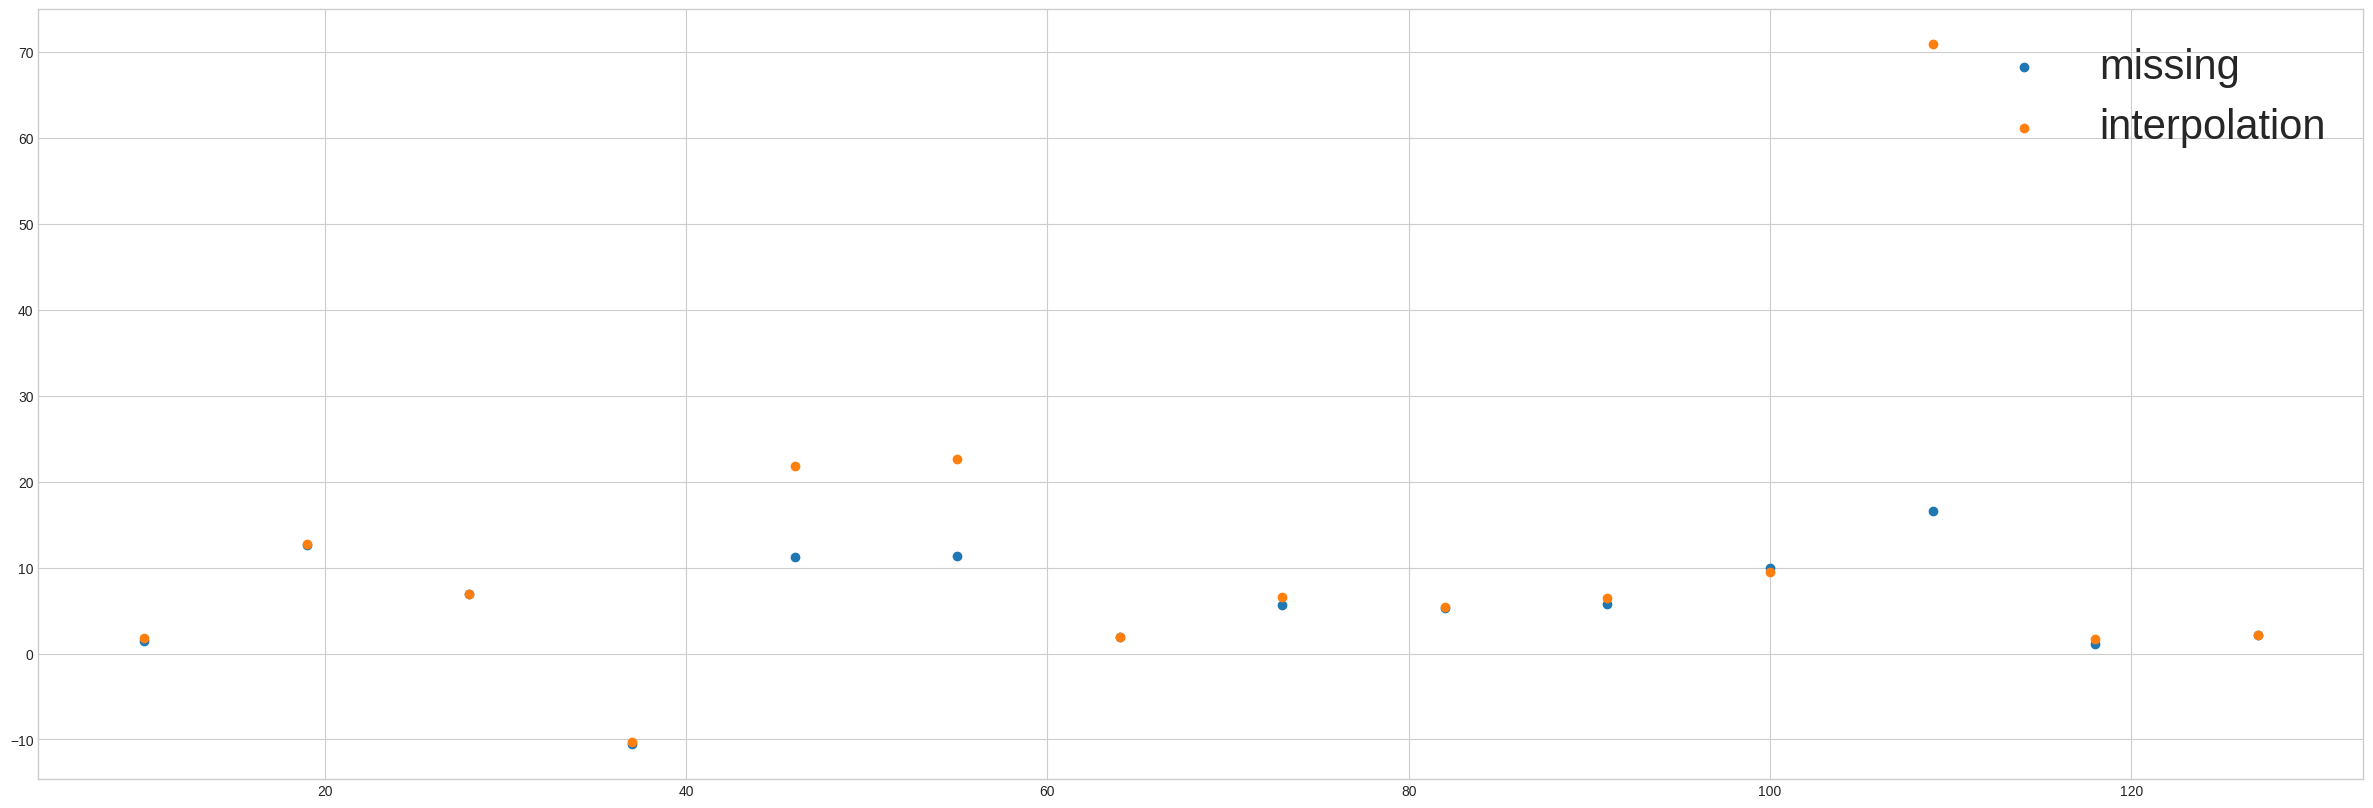

In [14]:
for i in range(3):
    plt.figure(figsize=(30, 10))
    plt.scatter(input_[(input_ * missing_index[i]) != 0].cpu().detach().numpy(), target2[i][(input_ * missing_index[i]) != 0] .cpu().detach().numpy(), label='missing')
    plt.scatter(input_[(input_ * missing_index[i]) != 0].cpu().detach().numpy(), model.pred(input_[(input_ * missing_index[i]) != 0])[1][i].cpu().detach().numpy(), label='interpolation')
    plt.legend(fontsize = 30)
    plt.show()

In [21]:
for i in range(3):
    true = target2[i][(input_ * missing_index[i]) != 0]
    imputation = model.pred(input_[(input_ * missing_index[i]) != 0])[1][i]
    print('missing imputation MAE :{}'. format(torch.mean(torch.abs(true - imputation))))

missing imputation MAE :3.634620497630217
missing imputation MAE :7.7544771844750136
missing imputation MAE :5.698184552483826


In [23]:
for i in range(3):
    true = target2[i][(input_ * missing_index[i]) != 0]
    imputation = model.pred(input_[(input_ * missing_index[i]) != 0])[1][i]
    print('missing imputation MAPE :{}'. format(torch.mean(torch.abs((true - imputation)/true))))

missing imputation MAPE :0.2617206767332212
missing imputation MAPE :7.394356803123389
missing imputation MAPE :0.4572936278797897


In [25]:
torch.sum(torch.abs((true - imputation)/true))

tensor(6.4021, device='cuda:0', dtype=torch.float64)